<img src="http://www.inf.puc-rio.br/wordpress/wp-content/themes/puc-di/assets/img/theme/logo.png" align="right" >

Árvores de Decisão com lógica probabilística
========
### Dissertação de Mestrado - Implementação
#### Orientador: Prof. Marcus Poggi | Aluno: João Vítor Amaro
------

## TODO:
- detalhar definições: definir notação
- mudar para solver robusto (gurobi)

In [100]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

from gekko import GEKKO

# Dados

In [13]:
X, y = make_classification(n_samples=200, n_features=2,
                           n_informative=2, n_redundant=0,
                           random_state=0, shuffle=False)

data = {'feature_names': ['test1', 'test2'],
       'class_names': ['class1', 'class2']}

# Satisfatibilidade

### PSAT
###### Definição:
$$
\left\{\begin{array}{r}
1 . p=1 \\
A p=\pi \\
p \geqslant 0
\end{array}\right.
$$

###### Exemplo:
$$
\operatorname{Min}(\operatorname{Max}) \pi_{4}=p_{1}+p_{2}+p_{3}+p_{4}
$$
subject to:
$$
\left\{\begin{array}{llllll}
p_{1} & +p_{2} & +p_{3} & +p_{4} & +p_{5} & +p_{6} & =1 \\
p_{1} & +p_{2} & & & +p_{5} & +p_{6} & =0.8 \\
p_{1} & & +p_{3} & +p_{4} & +p_{5} & & =0.6 \\
p_{1} & & +p_{3} & & +p_{5} & & =0.5 \\
p & \geqslant 0 & & & & &
\end{array}\right.
$$
yields $\left[\underline{\pi}_{4}, \bar{\pi}_{4}\right]=[0.2,1]$

In [165]:
pi = [0.8, 0.6, 0.5]
A = [[1, 1, 0, 0 ,1, 1],
    [1, 0, 1, 1, 1, 0],
    [1, 0, 1, 0, 1, 0]]

obj = [1, 1, 1, 1, 0, 0]

In [168]:
def psat_lp_model(A, pi, obj, maximize=True):
    m = GEKKO(remote=False)
    m.options.MAX_MEMORY = 5
    
    possible_worlds = len(A[0])

    p = np.array([m.Var(value=0, integer=False) for _ in range(possible_worlds)])
    aux = A*p

    obj = sum(obj*p.T)

    m.Equation(sum(p) == 1)
    for i in range(len(A)):
        m.Equation(sum(aux[i]) == pi[i])

    for pn in p:
        m.Equation(pn >= 0)

    if maximize:
        m.Obj(-obj)
        sense = -1
    else:
        m.Obj(obj)
        sense = 1
    m.solve(disp=False)
    
    return m.options.OBJFCNVAL * sense

In [171]:
print('min(pi4) ', psat_lp_model(A, pi, obj, False))
print('max(pi4) ', psat_lp_model(A, pi, obj, True))

min(pi4)  0.2
max(pi4)  1.0


### PSAT com intervalo

##### Definição:
$$
\left\{\begin{array}{l}
\text { 1. } p=1 \\
\underline{\pi} \leqslant A p \leqslant \bar{\pi} \\
p \geqslant 0
\end{array}\right.
$$

##### Exemplo:
$$
\operatorname{Min}(\operatorname{Max}) \pi_{3}=p_{1}+p_{3}
$$
subject to:
$$
\left\{\begin{array}{lllll} 
& p_{1} & +p_{2} & +p_{3} & +p_{4} & =1 \\
0.7 \leqslant & p_{1} & +p_{2} & & & \leqslant 0.9 \\
0.5 \leqslant & p_{1} & & +p_{3} & +p_{4} & \leqslant 0.7 \\
p_{j} & \geqslant 0 & & & j & =1,2,3,4
\end{array}\right.
$$
is then equal to $[0.2,0.7]$.

In [174]:
gte_pi = [0.7, 0.5]
lte_pi = [0.9, 0.7]
A = [[1, 1, 0, 0],
     [1, 0, 1, 1,]]

obj = [1, 0, 1, 0]

In [175]:
def psat_interval_lp_model(A, gte_pi, lte_pi, obj, maximize=True):
    m = GEKKO(remote=False)
    m.options.MAX_MEMORY = 5
    
    possible_worlds = len(A[0])

    p = np.array([m.Var(value=0, integer=False) for _ in range(possible_worlds)])
    aux = A*p

    obj = sum(obj*p.T)

    m.Equation(sum(p) == 1)
    for i in range(len(A)):
        m.Equation(sum(aux[i]) >= gte_pi[i])
        m.Equation(sum(aux[i]) <= lte_pi[i])

    for pn in p:
        m.Equation(pn >= 0)

    if maximize:
        m.Obj(-obj)
        sense = -1
    else:
        m.Obj(obj)
        sense = 1
    m.solve(disp=False)
    
    return m.options.OBJFCNVAL * sense

In [176]:
print('min(pi3) ', psat_interval_lp_model(A, gte_pi, lte_pi, obj, False))
print('max(pi3) ', psat_interval_lp_model(A, gte_pi, lte_pi, obj, True))

min(pi3)  0.2
max(pi3)  0.7


### CONDSAT


##### Definição:

Determine $\underline{\pi}_{m+1}, \bar{\pi}_{m+1}$ such that:

$$\underline{\pi}_{m+1}=\min A_{m+1} p \quad$$

$$\bar{\pi}_{m+1}=\max A_{m+1} p$$

subject to:

$$\left\{\begin{array}{lll}\mathbf{1} \cdot p & =1 & \\ \underline{\pi}_{t} \leqslant A_{i} p & \leqslant \bar{\pi}_{i} & i \in Q \\ A_{j} p-\pi_{j} & =0 & j \in C \cap(M \backslash Q) \\ \left(A_{t} \wedge A_{j}\right) \cdot p-\bar{\pi}_{t / j} \pi_{j} & \leqslant 0 & (i, j) \in T \\ 0 \leqslant\left(A_{t} \wedge A_{j}\right) \cdot p-\underline{\pi}_{t / j} \pi_{j} & & (i, j) \in T \\ \pi_{j} \geqslant 0 & & j \in C \cap(M \backslash Q) \\ p \geqslant 0 & & \end{array}\right.$$


##### Exemplo:

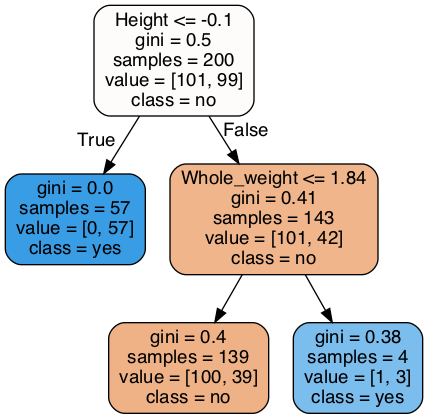

In [302]:
base64_data = 'iVBORw0KGgoAAAANSUhEUgAAAawAAAGjCAYAAABwniF5AAAABHNCSVQICAgIfAhkiAAAIABJREFUeJzs3XdUFFcbwOEfRao0KQqiEqXaY48tJrbYsWOJir1hS+yJHdFYY4m9YTfRGGsSG1YsKMWgUsVeAOmglJ3vD3S/bABhEVzA+5yz58SZ9955Z6O8zMyde9UkSZIQBEEQhCJOXdUJCIIgCEJeiIIlCIIgFAuiYAmCIAjFgqaqExDy7tWrVwQGBhITE8ObN29UnY6gQtra2piYmFCtWjXKlCmj6nQE4aMQBauICwwMZOvWrRw7dozg4GBVpyMUQfb29nTq1AlXV1eqVaum6nQEodCoiVGCRVNoaCjfffcdR44cwdbWlm5dnWnRogU1qlfHzMwMbW1tVacoqNCbN2+Iiori9j//4OXlxaHfDxMaGkrnzp1ZtmwZtra2qk5REAqcKFhFzOvXr5k7dy4rVqzAzs6WxYsW8U3btqipqak6NaEIkySJP//6i6nTphESEsrEiROZPXs2Ojo6qk5NEAqMKFhFyMuXL3F2dubu3bvMmzuXkSOGo6kp7toKeZeens76DRuZNXs2Tk5OHD58GAsLC1WnJQgFQhSsIiIwMJCOHTuiqanJkcOHcXR0UHVKQjF2714QnZ2dSU9P59ixY+LZllAiiIJVBDx69IiGDRtSpXJlfj90EFNTU1WnJJQA0dHRdO3WnbDwcK5du0aFChVUnZIgfBBRsFQsOTmZFi1akJiYyOWLFzA2NlZ1SkIJkpCQQNPmzdHQ0OTixYuULl1a1SkJQr6JF4dVbOjQoTx48IDjR48USLG64ePDlq3bePToUY4xJ//8ky1bt5GSkqJ0/38cOcKBX39Vut2+/fvZuWuX0u2KG5lMpuoUFBgYGPDH77/z9OlThg8frup0BOGDiIKlQl5eXuzdu5etWzZjY2NTIH0eOnSIYcOH4x8QkGPM8uUrGDZ8OHFxcUr37+6+kOkzZijdbvnyFXgsWpRr3BVvbxa4L+TFixdKH0NVgoNDmDBxIp9VscXMoiydOnfhzNmz+erL3tGR4SNGFGh+NjY2bN2ymb179+Ll5VWgfQvCxyQKlopkZGQwfvx4OnXsSPt27VSdTp6NGTOayd9PLrT+L168xKzZs3n2/HmhHaMgpaSk0KWrM1u3badtm9aMGjmCkNAQOndx5sLFi0r1tX2HJ6GhYYWSZ/t27ejYoQNjx44lPT29UI4hCIVNjJlWkb1793L37l1+3b9f1akoZeCAAapOoUj54ccfCQoK5vixo7T75hsAxrm5UbtOXVwHDyYsJOS97R8/fsy8+fO5ccPnvVfFBWHZ0qVUr1mTffv20b9//0I9liAUBnGFpSLr16/HuUsX7OyKxowEsbGxjBk7lho1a2FZ3pruPXpy4uTJLHHjJ0xg8JAhCtsCbt+me4+eVLa1xblrN3Z4enL6zBl69XYhOjpaITbwzh0GDByEdcVKVLGzY9jw4fJnaSNGjmTDxg0ADBkylPETJnzQOQUHh+CxaPEH9ZGb7Ts8qVmjhrxYAZQtW5a2bdpw/34E165ff2/7hIREgoNDMDIyon69eoWaq52dLc5durBhw4ZCPY4gFBZRsFTg+fPneHt7079/P1WnAmT+ll+nXj08d+6iefNmuA4aSEREBJ27OLPy51UKsd7eVzl/4YL8zxcuXqRxk6ZcvHSJpk2aYmJigtu48YwbP57fDh4kOTlZHhsZGcXXLVtx7fo1+vXtg20VW7Zs3cbgIUMBsLOzx7KcJZA5P16VKsoX85SUFHbt3s1XX7fEsWpVVq9Zk5+vJE+ioqKIiYmhVauWWfbZ2dkB4ONz8719ODk54nXuLF7nzrL7IwxK6devL1euXClWzwgF4R1xS1AFvLy80NDQoOXXXxfaMUaMHIW+vl62+548earw5+kzZhIR8QDvK5dp2KABAHNmz6Z9h45Mmz6dAd/2z3ZGcJlMxvjxE9DW1ubGtatUqlQJgEmTJlK/QcMs8dHR0cyeNYvZs36Ub2v0RWP+PnUKgO+/m0RGRgbeV68ydeoUateqlefz9Q8IYPPmzezes5fY2Fjs7e1wX7CAAd/2Jyoqil/Wrc+1j+7du1GtatU8HzPo7WTE5d4W2X9zcLAHIDLyZZ77+xhatWyJhoYGXl5e9O7dW9XpCIJSRMFSgYCAABwc7NHTy76gFARzMzPMzc2z3Rcd/Up+G+7Vq1fs2buX+vXqyYsVgJaWFkOHDuHsuXMc+v0wQ4cMztKPr58f/gEBTJs6RV6sAGpUr07vXr2yDGNXV1dn2tQpCtvq1q3D9Rs3ePz4MdbW1kqdY3x8PHv37WfLli343LyJoaEhvXr2YODAgTRp3Fged/fuPebMnZtrf/b2dtkWLJlMluUVAB0dHUJDQwGyLebvvo/Y2Filzqmw6enp4eBgz+3bt0XBEoodUbBU4NmzZ1SwLtxZBxYsmE/HDh2y3de6TVv5sOug4GAkSSIxKRGXPn0V4uLj4wEID89+5FpYWOZ2e/us00hVzeYHf/ny5bPMMv/u3bPExKT3nU4Wc+fNZ+myZSQnJ/NVixbs2L6N7t26ZftLgKOjA0kJ8bn2qaWlle32a9ev06RpM4Vtu3ftlJ/Lq1evsrRJSso8HxMTk1yP+7FZl7fm2bNnqk5DEJQmCpYKJCcno6+vr+o0AOSDIrS1tClVqpTCPlNTU/r17Ztt8QGIiYl9G5f1CiMjIyPLtpxuUULmbOPKuHDhAklJSTRt0oQpUybTqmVL1NWzfySrpqaGrq6uUv3/m5mpGf36KhZzGxsb+SKa9++HZ2nzroiZmWV/latKpUuXJjExUdVpCILSRMFSAUmSisxyIZU/qwxkDhLY6blDYV9GRgYJCQk53rq0scm87XXlyhU6deyosM/Pz68Qsv2/XTs92bZ9B1u3beWbdu2pUKECA77tz8ABA7G1raIQ+/z5cxa4u+fap6urK3Xr1Mmy3c7ONst3A/D06VPU1NQID7+fZV/A2yHqDRs2yLJP1dTU1JT+BUEQigJRsD5xtrZVMDc356+//yYtLU3hKstj0WJmzZ7NhfNeNG3SJEvb6tWqoampyalTp/FYuFC+PTz8PqfPnCnUvC0tLZkxfRrTp03l7LlzbNmylaXLluO+0INmTZsyaNAgevboTunSpYmNjWPzlq259tm8efNsC1ZOrKysaN6sGRcuXiQsLJwqVTKLf1paGnv27qV8+fJK9ScIwvuJYe2fOC0tLRa6uxMfH8+3AwZyy9eX0NAwli1fgfvChbRu1UphAMO/lS9fnvHj3Ljl64vr4CGc/PNPVq1eQ/uO2T87y4tKlSoCsGnTJm74+OQar6amRsuvv2bP7l08fviAZUuXEv0qmiFDh2JZ3pqxbm44OjrwOjkp10+vnj2Vznf69GmkpaXR28WFQ7//zjkvLzp3cSY8/D4bN6yXX0lv3LSZUto6zJu/QOljCIKQSVxhCQwZ7EpycjJTp02TT2yrqanJ0CGDWTB//ntvX3osXIiRkTE/r1rFDk/Pt8+9+mBsbMy8+QswNDRUKpfWrVrRqGFD1q3fwN279zh75nSe25qamjJxwngmThjPFW9vtmzZwsk//1Tq+Mpq07o1nju2M2z4CHr07AVkDiRZtnSpwsvEkiSRkZEhbsUJwgcQy4uoQK9evUCS2L9vr6pTUZCQkICvnx+JiYnUqF5d6fWTYmJi5KPixo0fz7Hjxwl/O/RbWU+fPsXAwAADA4N8tX8nJSXlgwZc5FV6ejo+N28ik8lo2KABGhoahX7M/Ort0gfU1Dhw4ICqUxEEpYgrLEHOwMCA5s2a5R74VkpKCi1btaZRo4YsX7ZMXqySkpL46++/qV2rdr5zsbKyynfbf/sYxQoyr0gbNcz6srQgCAVHFCwh33R1dSlTpgyr16wlLi6ODh06EBMTy/bt23ny5CmbNm5UdYqCIJQgomAJH2T3rp14LFrEqVOn2b7DE319fep8/jlH/jis1NWaIAhCbkTBEj6IkZERizw8WOThQVxcHAYGBjm+wCsIgvAhRMESCoyRkZGqUxAEoQQTvwoLBeaPI0fkw+I/RrsPJZPJPvoxBUHIP3GFJRQYd/eFRL+KVvoF3Py2y4/g4BB+WfcLfxw5SlxcHE0aN2bChPG5LvUik8moU7ce6RlZl5e3qWTDsaNHCitlQRDeEgVLKDBjxowmJeX1R2unrJSUFLp0debJk6f07eOCqakpBw8donMXZ06eOP7eQSKPHz8m4PZtalSvnmU5keyWFxEEoeCJgiUUmIEDBnzUdsr64ccfCQoK5vixo/JZKMa5uVG7Tl1cBw8mLCQkx7ahb5dS8fTcQa2aNT9KvoIgKBLPsIRcBdy+TfcePalsa4tz127s8PTk9Jkz9OrtIl+eBGD8hAkMHjJE/ufhI0bgNm4cT58+pV//b7GpXAVbe3uGDB0qXy8qu3aFZfsOT2rWqKEwZVLZsmVp26YN9+9HcO369RzbhoSEoqamhr2dXaHnKQhC9sQVlvBeFy5epH2Hjujp6fFN27ZoaGjgNm481tbluXcviGVLl2BqagqAt/dVol/9v4D5+fkTFR3F4T+O8JmNDS69e3Ht2nW2bd9BXFw8v/16INt2hSEqKoqYmBhcBw3Mss/ubRHy8bmpsOryv4WFhVKxYkUSExM5c/YsL168xMnJschPwyQIJYkoWEKOZDIZ48dPQFtbmxvXrsqXfZ80aSL1G+RtGqKIiAdMnTKZhe7uqKmpIZPJaNCwkXzF47yKioril3Xrc43r3r1btsvcBwUHA1CunGWWfQ4O9gBERr7Msd/Q0DDi4+P5rIotycnJ8u1169TBc8cOnJwcc81NEIQPIwqWkCNfPz/8AwKYNnWKvFgB1Khend69erFz165c+9DV1WX2rFnyGd/V1dVp0qQxt3x9efz4MdbW1nnKJTIyijlz5+YaZ29vl23BCn07CW92AyTenVtsbGyO/YaGhpKQkMCC+fPp6uxMZFQknp6ebNm6DeduXbnl41NkVpEWhJJKFCwhR2FvBxrY2ztk2Vc1m6KQHQsLC3R0dBS2vZskNzExKbsm2XJ0dCApIT7XOC0trWy3a2trA/9fuv7f3j1Pe5dXdrZt24q2tjbVq1UDMlchbvzFFxgZGbFk6TIO/f473/bvn2t+giDknyhYQo5iYjKvOExNs16VZGRk5KkPXV2dHPcps7KNmpraB828Xq5cOQDu3w/Psu9dETMzM8+xfU4rB7dr144lS5cRGBiY79wEQcgbUbCEHNnYZN4qu3LlCp06dlTY5+fn91Fzef78OQvc3XONc3V1zba42NvZoaamRnj4/Sz7AgICAGjYMPsBF48ePeL6jRvUr1ePihUrKux715+5uUWuuQmC8GFEwRJyVL1aNTQ1NTl16jQeCxfKt4eH3+f0mTMfNZfY2Dg2b9maa1zz5s2zLVhWVlY0b9aMCxcvEhYWTpUqlQFIS0tjz969lC9fPserqFcxMfTs1Zvhw4ayft06hX3vFkFs1qypsqckCIKSxHtYQo7Kly/P+HFu3PL1xXXwEE7++SerVq+hfccOHz0XR0cHXicn5fp53/RO06dPIy0tjd4uLhz6/XfOeXnRuYsz4eH32bhhvXxgyMZNmymlrcO8+QsAqFmjBl80asSmzVuY+cMP+Ny8yfUbNxg/YQJ/nzpF927daFC//kf5HgThUyausIT38li4ECMjY35etYodnp6YmprSr28fjI2NmTd/AYaGhqpOMc/atG6N547tDBs+gh49ewFgbGzMsqVLFV4mliSJjIwM+TM2NTU1fj90kGHDR+CxaDEeixbLY0eNHMHSJUs+7okIwidKTVLmybdQIHr16gWSxP59e1WdilJiYmLkI+nGjR/PsePHCX87XLw4SU9Px+fmTWQymdIv/j548ICg4GCMjY1xcnTEwMCgEDMtHL1d+oCamvx2piAUF+IKS8hRSkoKLVu1plGjhixftkxerJKSkvjr77+pXau2ijPMH01NTRo1zNuLz/9VqVIlhXfSBEH4eETBEnKkq6tLmTJlWL1mLXFxcXTo0IGYmFi2b9/OkydP2bRxo6pTFAThEyIKlvBeu3ftxGPRIk6dOs32HZ7o6+tT5/PPOfLH4fcuxyEIglDQRMES3svIyIhFHh4s8vAgLi4OAwMD1NXF4FJBED4+UbCEPDMyMlJ1CoIgfMLEr8qCypw4eZJ9+/erOo0PkpiYmOdYmUxWoHGC8KkRBUtQmSVLljJl6jRVp6G0W76+fNOuPabmFhgam2BZ3pqRo0YRH591ct7g4BAmTJzIZ1VsMbMoS6fOXbJdWiWvcYLwKRO3BAVBCT43b9K6TVs0NTXp28eFMmXKsP/AATZu2oyvrx/eVy7Ln/GlpKTQpaszT548pW8fF0xNTTl46BCduzhz8sRx+aCVvMYJwqdOFCxBUMLatb+QkpLCVe8r1K5VC4C5c+bQuk1bzpw9y8FDh+jZowcAP/z4I0FBwRw/dlQ+k8Y4Nzdq16mL6+DBhIWEKBUnCJ86cUuwhHj9+jVz5s7F1t4eHT197B0dGTlqFAkJCQpxXufPM9bNDQcnJyrafEbffv1Zv2GjwnIhw0eMYJDrYEJDwxg2fDgVbT6jZavW7Nq9G4DlK1ZSr34Dylpa0b5DR0JCFGe7cOnTl4Uei7ji7Y1Ln75YlLOkes2aLP5pSa7PZ2JjYxkzdiw1atbCsrw13Xv05MTJk/k+34J25W2heles3hk0aCAAN27ckG/bvsOTmjVqKEz7VLZsWdq2acP9+xFcu35dqThB+NSJglVCjBk7FveFHjRv1oyfFi+mfbt27Ny1m2/atZfHnPPyonWbtuzbf4C2bdowZPBgHj16xOgxY5gxc6Y8zs/Pn79PnaLF11/jffUqX7VoweUrVxg4yJUOHTsxbfp0rK2tadqkCWfPnaN127YKhejM2bNs276NDh07kZqayvBhQ9HT1WP6jBmMGDkyx3N4/PgxderVw3PnLpo3b4broIFERETQuYszK39epfT5FrS0tDTatmnDmDGjs+x79OgxACYmmWuHRUVFERMTQ6tWLbPE2tnZAeDjczPPcYIgiFuCJcKbN2/YtXsPHdq3Z+uWLfLtlStXYcLEiQQHh2Bvb8e+ffvQ1NQkNDgIY2NjAKZOmUwVO3uOHjvG4kWL5G2fP3/O/HnzmDljOgAuLr3p0LETXufP809AAPb2mT9MXQcPYYenJ6GhYfJtAGFh4SxbupSJE8YDMG/uXFq3acvWbdsZOXJktkt5TJ8xk4iIB3hfuUzDBplrU82ZPZv2HToybfp0BnzbnzJlyuT5fP8rKiqKX9atz/X77N69G9WyWVG5VKlSrPr55yzbX758yS/r1lGqVCk6vp3JPig4GIBy5SyzxDs42AMQGfkyz3GCIIiCVSK8u53ndf48vn5+fF47c46/sWNGM2Swq3yJ+okTJjJ27Fh5sQJITU3F2NiIuDjFEW4aGhpM/v47+Z9r1awJwNdffaVQDL788kt2eHpy5+4dhe3GxsZMGD9O/md1dXWmT5/GOS8v/v77VJaC9erVK/bs3Uv9evXkxQoyl7wfOnQIZ8+d49Dvhxk6ZHCez/e/IiOjmDN37nu/SwB7e7tsC1Z2jh0/ztBhw4mMjGTF8uXUqF4dgNC3kwKXKZN1teZ3cxHGxsbmOU4QBFGwSgQ9PT1m/fgjP86aRd169XFycuSrFi1o164dbdu0kc9G7ujoQHR0NMuWr+Dq1atEREQQEhpKfHw8VlZWCn1aWVmhpaUl//O7ImBlpXgloKGReVc5NTVVYbudra18fal33hWB8PCwLOcQFByMJEkkJiXi0qevwr53w8Xftcvr+f6Xo6MDSQlZh57/17/POydhYeFM+u47jh47hq1tFXbt9KRVy//f1tPW1gYyC/F/JSUlAWBiYpLnOEEQxDOsEmPmjOmEBAXx4w8z0dPVY/2GjXTq3IXqNWvy/PlzAJYsXUaFSjYscHcnLS2NVq1asm3rFpo0bpylP319vWyPk9dpmSwts97i0tfXB8j2Cig6OhoAbS1tSpUqpfDJXIOrL1X/ddWTl/P9LzU1NXR1dXP95LbcyK7du/m8bl28zp9n8aJF3Pb3VyhWAOXKlQPg/v3wLO3fFSczM/M8xwmCIK6wSoTU1FSSk5OxsanE3DlzmDtnDs+fP2ehhwdr1v7CmrVrGT9uHNNnzMDc3Jzge3cV1nFauNCjwHMKDcu6TlbEgwcA2Ns7ZNlX+bPMJevt7OzY6blDYV9GRgYJCQno6WUW0byc74L587Mc4/nz5yxwd881d1dX12yfsUHmLcCBg1z5olEj9uzeRcWKFbONs7ezQ01NjfDw+1n2BQQEANCwYQOsLC3zFCcIgrjCKhHOnjtHGTNz9u7bJ99Wrlw5vv8u8xlUTEwMDx4+RCaT0a2rs0KxevToEX7+/gWeU3BwSJbh7tu3bwegdu1aWeJtbatgbm7OX3//TVpamsI+j0WLKWNmzvW3Q8bzcr7ZiY2NY/OWrbl+wsKy3rJ8Z+bMHzAyMuLXA/tzLFaQeUu1ebNmXLh4kbCw/189paWlsWfvXsqXL0/dOnXyHCcIgrjCKhGaNG6MhYUF8xcswNrams9r1yY0LEx+5dS+fXsc7O0pXbo0+w/8yjfffIOjgyOXr1xh1uzZGBoakpiYSFBQsHxk2ofKyMiga/duzJ83D3t7ew4d+p1Vq9fQq2dPmjVtmiVeS0uLhe7uDBs+nG8HDGTKlMkYGhjyx5EjuC9cSOtWreS3LvNyvtlxdHTgdXJSvs8pJiaGfwID+bx2bZavWJFtzJdffknHDpkjBadPn0bHTp3p7eLCjBnTMTEx4aeflhAefp+jR/6QP+PLa5wgfPIk4aPr2bOn1LNHD0mWnlZgn7//+lOysrKSAPlHR0dHWjB/vjxm/769UunSpeX7y5QpI23ftlX69cB+SV9fX9LU1JRk6WlSvbp1JUdHB4X+o16+kABpxPBhCtt3bN8mAdK+vXvk20xNTaVWLVtKAwcMkNTV1eXHa/Hll1Lki+fyuC+bN5esra0V+vt55UpJR0dH3kZTU1MaOWK4FPXyhdLnW9CfI38cVjhedp/vv5uk0GbP7l2Svr6+fL+xsbG0YvnyLH3nNa4gPj179JB69uyp6n8GgqA0NUmSpI9VHIVMvXr1Akli/769BdpvcnIyAbdv8/DhQ8zMzKherRoWFhYKMdHR0fj6+WFpaUlVJyf5b+/R0dHExMRia1vlg/MwL1uO+vXqceL4MWJiYvC5eZPyVuWpWtUpT+0TEhLw9fMjMTGRGtWrU6FChWzj8nK+RUF6ejo+N28ik8lo2KBBjoM68hr3oXq79AE1NQ4cOFAo/QtCYREFSwUKq2AVFf8uWELRIwqWUFyJQReCIAhCsSAKllDgLMuVw8zMTNVpCIJQwohRgkKBC/D3U3UKgiCUQOIKSxAEQSgWxBXWJ+jEyZPEx8fj0ru3qlNR2sZNm4mMjATAycmRbl275rsvmUyW56mmClJ6ejoaGhp5er8qp9i/T53ixg0fAHR1dZk0cUKh5CoIRYm4wvoELVmylClTp6k6jXxZtXoVHosWscNzB+fPn882xt7RkeEjRmS7Lzg4hAkTJ/JZFVvMLMrSqXMXzpw9m+tx39dnXp04eZK69epjYGRMOavy9OnbjwsXL+Yr9tq16+zw3MFPS5aw0KPgp9YShKJIFCyh2GnerBnB9+7x88qVWfZt35G5Nld2UlJS6NLVma3bttO2TWtGjRxBSGgInbs451g4cuszr/bu20enzl2IjYtl8vff0bFDe44dP07nLs4EBQUrHfvjDzMJvnePrs7OH5SXIBQn4pagUOw9fvyYefPnc+OGD/5vJ4zNzg8//khQUDDHjx2VL0c/zs2N2nXq4jp4MGEhIUr3mRepqalMmToNfX19bt64IV+PzGPhQipUsqFP377cuumjdKwgfGrEFVYxMG78eJp/2YJnz55l2Tdi5EjaftNOvh6V1/nzjHVzw8HJiYo2n9G3X3/Wb9goX/QwJwMHufLtgIFZti9a/BPNv2xBenq6fFtsbCxjxo6lRs1aWJa3pnuPnpw4efIDzzL/EhISCQ4OwcjIiPr16uUYt32HJzVr1JAXK4CyZcvStk0b7t+P4Nr160r3mRd37t7lyZMntG/XTmHxTAsLC9q0bo2fvz9xcXFKxwrCp0YUrGKgShVbLl2+zKHfDytsf/r0KVu2bqNMmTJoaWlxzsuL1m3asm//Adq2acOQwYN59OgRo8eMYcbMme89xs1bN7l562aW7aGhIVy6fBmZTAZkXnnUqVcPz527aN68Ga6DBhIREUHnLs6s/HlVwZ20EpycHPE6dxavc2fZvWtXtjFRUVHExMTQqlXLLPvs7DJXSvbx+f/556XPvHr69CkA9evXz7Lv3bbAO3eUjhWET424JVgM9O3jwuQpUzh48CBjRo+Sbz/w62/IZDIGDcq8Mtq3bx+ampqEBgfJfzufOmUyVezsOXrsGIsXLfrgXKbPmElExAO8r1yWL2U/Z/Zs2nfoyLTp0xnwbf9sl3uPioril3Xrc+2/e/dueV6eXhlBwZnPfsqVy7qw5LsZ6iMjXxb4cQGqVM6cn/HcuXN8N2miwr67d+8CEBh4h8ZffKFUrCB8akTBKgbMzc1p9803nDh5kpcvX8oneN2/fz/ly5endatWAEycMJGxY8cq3EpKTU3F2NiIuLjcl4bPzatXr9izdy/169WTFyvIXBpk6NAhnD13jkO/H2bokMFZ2kZGRjFn7txcj2Fvb1coBSs0NHNtruyKaaVKlYDMW52Fwc7Olnp163Lm7Fk2b9lK7149kclk7Nq9h19/+w1AfstWmVhB+NSIglVMDBjwLUePHeP3w38wYvgwIiIecO36daZPmyp/l8jR0YHo6GiWLV/B1atXiYiIICQ0lPj4eKysrD44h6DgYCRJIjEpEZc+fRX2xcdnFsTw8OxH0zk6OpCUkHvEHhwhAAAgAElEQVTR1NLS+uA8s6OtrQ38f9n5f0tKylwjy8TEpFCOra6uzpYtm+ncxZnhI0YwYeJEZDIZMpmMYUOHsGHjJqpVq6p0rCB8akTBKiY6duiAiYkJBw8eZMTwYex/O9P2wH8NlFiydBmz58xBW1ubL5s3p1WrlsyYMZ3ly1dwPyIiX8d99er/q/dGR0cDoK2lTalSpRTiTE1N6de3L1VzuDpSU1NDV1c3XzkUhHLlygFw/354ln3vipiZmXmhHb9G9eoE+Ply4NffuHv3DuXKWdK6dSu8vDLfJfv3VaUysYLwKREFq5jQ1tamd6+ebN6ylejoaPbv30/jL77A3j5zwEBkZCTTZ8zA3Nyc4Ht3MTAwkLd9txLv+6ihJh9Y8W9BwUHy/678WWUgc5DCTs8dCnEZGRkkJCSgp6eXbf/Pnz9ngbt7rnm4uroWypLw9nZ2qKmpER5+P8u+gLfD1hs2bJBlX0FITU3l/v0IzMxMGTLYVWHf4sU/YWlpKb9VqUysIHxqRMEqRgYMGMD6DRv5ackS/Pz92bhhg3zfg4cPkclkdOvqrFCsHj16hJ+/P2XLln1v3zY2Npw6fZq0tDT51VPgnTsKL8za2lbB3Nycv/7+WyEOwGPRYmbNns2F8140bdIkS/+xsXFs3rI113Ns3rx5oRQsKysrmjdrxoWLFwkLC6dKlczim5aWxp69eylfvnyhHBcyF5p0qlaNPi4u7N61U7798ePHHDx0iMGug/IVKwifGjGsvRhp1LAh9vZ2LF+xEj09PXr17CHf52BvT+nSpdl/4FeOHjtGSEgo23d40qRZcwwNDUlMTMwyo8K/NWjQgNTUVFwHD8Hr/Hk2b9lK127dMDIyksdoaWmx0N2d+Ph4vh0wkFu+voSGhrFs+QrcFy6kdatWNGncONv+HR0deJ2clOunV8+eBfeF/cf06dNIS0ujt4sLh37/nXNeXnTu4kx4+H02blifp7n9/mvFyp8ppa3DvPkLcowxNjbm66++4reDB9m6bTsxMTHc8PGhcxdnrK3L89PixfmKFYRPjShYxUz/fv3JyMigW9euGBoayrcbGBiwZfMmUlNT6eLcFQcnJ76fPJkF8+exccN6MjIyqFGrVo79fjdpIu2++YY9e/fydctWzJ03jx7du2cZ8TdksCs/r1zJkaNHqVe/AfaOjkyfMQPXQQPZu2d3vn7ofyxtWrfGc8d2goKD6dGzFy1bteba9essW7pU4WViZchkMjIyMsht4e4tmzdRr25dhg4bhqm5BQ0bfYG6ujq7d+1SuCJWNlYQPiVqUm7/0oQC16tXL5Ak9u/bW+B9R0dH4+vnh6WlJVWdnOQFJDo6mpiYWGxtq7y3fWRkJE+ePqVWzZrvLT4JCQn4+vmRmJhIjerVqVChQoGeR06q16xJxQoVOXH8WL77SE9Px+fmTWQyGQ0bNEBDQ+ODcnJf6EHlyp/Rx8XlvXGSJHH7n38IDw+nzuefU7FixQ+OHeQ6mGPHjxP18kWe8+3t0gfU1DjwduCOIBQX4hlWCWNqakqrlllnczA1NcXU1DTX9ubm5pib5z5azsDAgObNmuUrR1XT1NSkUcOGBdJXaGgY27Zv49yZM7nGqqmpUbNGDWrWqFGgsYLwqRC3BIVix8/fn94ufVix8mdVp0JYeBhHDv/x0a4w39m2fQe9Xfpw/sKFj3pcQVAlcYUlFCttWrfm0aPHyGSyXJ8bfQxt27RRyXElSUImk1Gvbl0MDEqrJAdB+NhEwRKKleXLlqk6hSJhsOsgMcRd+OSIW4KCIAhCsSAKlpAvJ06eZN/+/apOQxCET4goWEK+LFmylClTp6k6DUEQPiGiYAmCIAjFgihYQo4kSSoSI/GKi+wmDxYEoeCIgiVk4R8QQOs2bTExNUPfwJBGXzTm5J9/5trO6/x5xrq54eDkREWbz+jbrz/rN2xUWHDw9evXzJk7F1t7e3T09LF3dGTkqFEkJCQo9JXXuII2fMQI3MaN4+nTp/Tr/y02latga2/PkKFD5etm/dvdu/fo0LETFuUsKW1oRIOGjTh46FCh5igInyoxrF1Q4HX+PO07dMTUNHN5i7i4OA4e+p0uzl3xOnc2x6XZz3l50abtNxgZGdG3jwumpmacPn2a0WPGcP9+OIsXLQJgzNixeO7cxbf9+1G79ueEh4exafMWbt/+h8uXLsr7y2tcQfPz8ycqOorDfxzhMxsbXHr34tq162zbvoO4uHh++/X/0xldunyZdu07YG5uxojhw9DR0eXYsWP07NWbuXPm8OMPMwstT0H4FIm5BFWgMOcS/BAymYy69eoT8eABN65dk887eO9eENVq1KBvnz7ydbC++rolYeHhPIzIXF9qxMiReO7cxbMnjzE2NgYyr5Kq2NljZGTInX/+4c2bNxgam9Dum284/Pv/r0JWrV7DhIkTuXfnDvb2dnmO+6+oqCh+Wbc+1/Ps3r1bjosgNmjYCJ+bN5k6ZTIL3d1RU8tcJ6xBw0aEhYcTEx0FZN4urd+gIREPHhDg5ytf0TktLY127Ttw6fJlAvz8ss1T1cRcgkJxJa6wBDlfPz/8AwIYOGCAwiS5jo4O/Lxy5Xuf0UycMJGxY8fKixVkLkZobGxEXFw8gPzWoNf58/j6+fF57doAjB0zmiGDXdHR0VEq7r8iI6OYM3durudpb2/33lV7dXV1mT1rlnzyX3V1dZo0acwtX18eP36MtbU1t3x9ueXrS4/u3eXFCqBUqVIMHDiAs+fOcer06SJZsAShuBIFSwV0dHSIi41VdRpZhIaGAlC9evUs+8aOGf3eto6ODkRHR7Ns+QquXr1KREQEIaGhxMfHy3+g6+npMevHH/lx1izq1quPk5MjX7VoQbt27Wjbpo181vS8xmWXQ1JCfK7nqaWl9d79FhYWWYqiiYkJAImJmc+xQkJCgMwFJ/+rztuFIENCcl5/TJVSUlIok4eJkAWhqBGDLlSgTJkyREZFqjqNLCIjM293lS9vlUtkVkuWLqNCJRsWuLuTlpZGq1Yt2bZ1S5YFHWfOmE5IUBA//jATPV091m/YSKfOXahesybPnz9XOu7f1NTU0NXVzfWT23IiurrZX8EB8lGTUVHRANjYVMoS8+bNG4APXraksERFR1GmTBlVpyEIShNXWCrg5OTEtm3bkCSpSC14+O6H7/Xr13Hp3Vthn+fOnchkEoMGDsjSLjIykukzZmBubk7wvbsKiwwuXOgh/+/U1FSSk5OxsanE3DlzmDtnDs+fP2ehhwdr1v7CmrVrWTB/fp7j/uv58+cscHfP9TxdXV2p+/YqKL8++8wGgEuXLtGxQweFfd7eV9/GVP6gYxQGSZK4c+cugwa5qjoVQVCauMJSgUaNGhEfH4/PzZuqTkVB/Xr10NXV5ezZcwrb79y5i+vgIVy4cD7bdg8ePkQmk9Gtq7NCsXr06BF+/v7yP589d44yZubs3bdPvq1cuXJ8/913AMTExCgV91+xsXFs3rI1109YWJgyX0u2Pq9dGy0tLU6dOp1l3/nz59HQ0FDZTO7v43PzJvHx8XyRw2hPQSjKRMFSgZo1a1KxYkUOFbH3dcqWLcuE8eMIuH2bUaNH43PzJp47d9K3Xz80NTUZMWJEtu0c7O0pXbo0+w/8ytFjxwgJCWX7Dk+aNGuOoaEhiYmJBAUF06RxYywsLJi/YAFe588TFxfHzVu3mDgpsxC1b98eIM9x/+Xo6MDr5KRcP7169vzg78rKyoqxY0bj6+fHmLFj+ScwkKCgYObMnctvBw/Sv18/7OxsP/g4Be3gwYNUqlSJmjVrqjoVQVCeJKjE7NmzJQsLCykxPk6SpacVmU/am9fStKlTJA0NDQmQAMnS0lLav2+vQtyXzZtL1tbW8j/v37dXKl26tLxNmTJlpO3btkq/Htgv6evrS5qampIsPU36+68/JSsrK3kcIOno6EgL5s9X6D+vcQX9qVe3ruTo6JBl+6wff5AAKfD2bfm218lJ0vhxbgo5AtLIEcOl18lJKv9/+d9PYnycZG5uLs2ZM0fVf/0FIV/Ee1gq8vLlS+zt7RnnNpa5c+aoOp0skpKSCLh9G0NDQ+xsbXMdWQcQHR2Nr58flpaWVHVykj+fi46OJiYmVj5UPjk5mYDbt3n48CFmZmZUr1YNCwuLLP3lNU7VXr58iZ+/P9ra2tSsUUM+orComT1nDqtWryE4OLhIfo+CkBtRsFRo+fLlzJw5k8Dbt+UP8QWhMDx8+JCq1WuwYMECJk6cqOp0BCFfRMFSobS0NGrWrImVpSUnTxynVKlSqk5JKIHezb7x9NkzAgICxN8zodgSgy5UqFSpUvz222/43LzJqNHvfzFXEPJr/IQJXL9xg3379oliJRRromCpWLVq1di1axfbd3iywH2hqtMRSpgF7gvZuGkze/bsoVatWqpORxA+iHhxuAjo1KkTa9aswc3NjUePHrJm9Wrxm7DwQdLS0hjr5sbWbdtZs2YNnTp1UnVKgvDBxDOsIuTo0aP07duXBvXrs3nTRmxsbFSdklAMRUREMHTYcK7fuMGePXtEsRJKDHFLsAjp1KkTly5d4umzZ1SrUZPZc+aQnJys6rSEYiI5OZnZc+ZQrUZNnj57xqVLl0SxEkoUcYVVBKWlpbF69WrmzZuHlpYWroMG0r17d+rVrVuk5h4UVE+SJHxu3uTgwYNs276D1NRUZs2ahZubm7itLJQ4omAVYS9fvmTdunVs3bqVhw8fYmhoSLVqVTEzNctxTajCIpPJUFNTEwUzG+np6WhqftzHwa9fvyYyKpI7d+4SHx9PpUqVcHV1ZdSoUeKlYKHEEgWrmPD39+fq1avcuXOHmJgYXr9+/VGPHxgYyMuXL/nqq68+6nGLuidPnuDr60ubNm3yNBtIQdHR0cHExISqVavyxRdfiLkBhU+CKFhCrkJCQqhZsyYLFy4UsyT8R3x8PFWrVqV9+/Zs3LhR1ekIQokmCpbwXpIk0bp1ayIjI/Hx8RHPRbJx4MABXFxcOH36NF9//bWq0xGEEksULOG9duzYweDBg7l8+TKNGjVSdTpFVpcuXbh37x7+/v4f/fmiIHwqxLB2IUevXr1iypQpjB49WhSrXKxevZqnT5+yePFiVaciCCWWuMIScjRkyBBOnDjB3bt3MTY2VnU6Rd7y5cuZPn06fn5+ODk5qTodQShxRMESsnXp0iWaN2/O/v376VkAK/R+CjIyMmjYsCH6+vp4eXnl6RWAe/fucfny5ffG6Ovr4+LiolQuJ06cID4+Xul2glCUiYIlZJGamsrnn39OxYoVOXnypKrTKVb8/f2pV68e69evZ8iQIbnGb9iwgZEjR743pkKFCjx8+FCpPFq0aEFYWBiPHj1Sqp0gFGVi8lshiyVLlnD//n2OHj2q6lSKnVq1auHm5saUKVPo2LEjZcuWzVO7iRMn0rlz52z3iUEcgpBJFCxBQUREBB4eHsyePZvKlSurOp1iacGCBRw+fJhJkyaxe/fuPLWxt7enRYsWhZuYIBRzYpSgoGDs2LHY2NgwadIkVadSbOnp6bF27Vr27NnDsWPHCrRvLy8vxowZg729PRUqVKBPnz6sX7+ejIyM97Z7/fo1s2fPpkqVKmhra2NnZ8eIESNISEhQiIuNjWX06NFUr16dcuXK0a1bN06cOFGg5yAI+SWusAS5ffv2ceLECS5evCheEP5A7dq1o2fPnowdO5avvvoKfX39D+7z3LlztG7dGiMjI/r27YuZmRmnTp1i1KhRhIeH89NPP+XYdvTo0Xh6evLtt9/y+eefExYWxqZNm7h9+zZXrlwB4PHjxzRr1ozIyEgGDBiAkZERf/31F506dWLZsmVMmDDhg89BED6IJAiSJMXFxUlWVlbS8OHDVZ1KifHs2TPJxMREmjJlSo4x69evlwCpVq1akrOzc5ZPjx495LHDhg2TtLW1pZiYGPm2lJQUydLSUnJ0dFTo98svv5Ssra0lSZKk169fS6VKlZI6d+6sEPPzzz9LgBQUFCRJkiT169dPAqSrV6/KY968eSN9/fXXkpaWlhQdHZ3/L0MQCoAoWIIkSZI0cuRIyczMTIqMjFR1KiXK+vXrJU1NTenWrVs57gckAwMDycLCIsunfPny8ti7d+9KAQEBCu3j4uIkJycnycrKSmH7vwtWUlKSVKpUKcnQ0FAhj4yMDCkxMVFKT0+XoqOjJTU1Nal+/fpZcty7d68ESJs2bcr39yAIBUHcEhS4ceMGGzduxNPTEzMzM1WnU6IMGzaMXbt2MWLECLy9vdHQ0Mg27qeffsp1eLujoyPR0dEsW7YMb29vIiIiCAkJIT4+Hisrqxzb6enpMXv2bH744Qfq1KmDk5MTX331Fe3bt6dt27ZoaGgQFBSEJEkkJibSu3dvhfbx8fEAhIWFKXn2glCwxKCLT1x6ejojRoygWbNm9O3bV9XplDjq6ups3ryZgIAAfvnllw/qa8mSJVhbWzN//nzS0tJo1aoV27dvp0mTJrm2nTlzJqGhofz444/o6emxfv16OnbsSLVq1Xj+/DnR0dEAaGtrU6pUKYWPqakp/fr1o1q1ah+UvyB8KHGFlQ+nTp3K84uc3bt3L9LTGq1cuZI7d+7g5+cnFmcsJA4ODkyePJmZM2fi7OxMhQoVlO4jMjKSadOmYW5uTkhICAYGBvJ97u7u722bmppKcnIyNjY2zJs3j3nz5vH8+XPc3d1Zs2YNq1evpl+/fgDY2dmxa9cuhfYZGRkkJCSgp6endN6CUKBUfU+yOOrUqZME5OkTGBio6nRz9ODBA6l06dLSvHnzVJ1Kiff69WvJ0dFRat++vcL2d8+w1q1b9972N27ckABp1KhRCtsfPnwoaWhovPcZ1smTJyVA2rlzp0LMgwcP5H2+efNGMjc3lwwNDaXU1FSFuPnz50uAdPHiRaXOWRAKmihY+RASEiLduHFD/tm9e7cESG3atFHYfuPGDSklJUXV6eaoc+fOkr29fZHOsSTx8vKS1NTUpEOHDsm35bVgxcfHS6VLl5bKlCkjHTlyRAoODpa2bdsmWVtbSyYmJpKhoaF07949efy/C1Z8fLxkYWEh2dnZSefOnZNiY2MlHx8fqWvXrhIgHTt2TJIkSdq8ebMESL169ZJu3rwphYSESEuXLpW0tbWl1q1bSzKZrBC+FUHIO1GwCoCfn58ESC4uLqpOJc8OHjwoqampSWfOnFF1Kp+UQYMGSZaWlvKh6XktWJIkSQcOHJBKly4tv3ovU6aMtGPHDum3336T9PX1JU1NTXnsvwuWJEnSqVOnJCsrK4Wrfx0dHcnd3V3hGKtWrZJ0dHTkMZqamtLIkSPFkHahSBAFqwDkVrDc3NykwYMHS48ePZJGjx4tmZmZyfd9++23Ur9+/bK08fDwkJo2bSqlpaXJt8XExEijRo2SqlWrJpUtW1bq2rWrdPz4caXzjY+Pl6ytraWBAwcq3Vb4MNHR0ZKFhYU0ZsyYfLWPioqSTp06Jf3zzz8KVzxRUVFSSEjIe9smJSVJ3t7e0v79+6UzZ85IL168yDYuPj5eOn/+vHT8+HHp4cOH+cpTEAqDKFgFILeC9eWXX0oODg5SzZo1JUCqU6eOfF/VqlWzvPQpSZI0ePBgCZDevHkjSZIkPXr0SLKxsZH09fWlUaNGSdOmTZM+//xzSV1dXVqxYoVS+Y4fP14qU6ZMjj+whMLl6ekpqaurS5cvX1Z1KoJQrIhh7R9JUFAQlpaW3L17l5s3byrdftq0aURERHDmzBl++eUXPDw8uHr1Ki1atGDq1Km8evUqT/34+/uzdu1ali5dioWFhdJ5CB/u22+/pWXLlowcOZK0tDRVpyMIxYYoWB/R/PnzcXR0VLrdq1ev2LNnD/Xr16dhw4by7VpaWgwbNozU1FQOHTqUaz8ymYwRI0bwxRdfMGjQIKXzEArOxo0bCQ8PZ9myZapORRCKDfEe1kdibm5O/fr189W2oGYhWLNmDb6+vvj6+op3rlTMxsaGmTNnMm/ePHr27EmVKlVUnZIgFHniCusj0dbWVir+37f4CmIWgmfPnjFr1iwmT55M1apVlT8BocBNnjwZBwcHhg0bhiQW/haEXIkrLBVTU1NDJpNl2R4UFCT/73cLKX7ILARubm6YmJgwffr0AshaKAiampps2LCBxo0bs3v3bvr376/qlAShSBNXWCpmY2NDRESEwsP3wMBAQkND5X+2tbXF3Nycv/76K8tDeg8PD0xMTLh+/XqOxzh58iQHDx5k7dq1BbIuk1BwGjRowMiRI5kwYQKRkZGqTkcQijRRsFSsYcOGpKamMmjQILy8vNi8eTPOzs4YGRnJY7S0tPDw8CA+Pp7+/ftz69YtQkNDWbZsGQsWLKB169Y5ToCanJzMmDFj6NOnD+3bt/9YpyUoYeHChejq6jJ16lRVpyIIRZuqx9WXBHl5D+vfsw78W1JSktSuXTv5zALly5eXpk2bJk2bNk3hPSxJyt8sBJMnT5YMDQ2lJ0+efNhJCoXq3cwjp0+fVnUqglBkqUmSeNpbFERGRvLkyRNq1ar13hF8CQkJ+Pr6kpiYSI0aNd478/c///xDnTp1WLVqVa5rLQmq17VrVwIDAwkICEBHR0fV6QhCkSMKVgklk8lo1qwZ6enpeHt7o64u7v4WdU+fPqVq1aqMGzeOefPmqTodQShyxE+xEmrjxo1cv36dDRs2iGJVTFhZWTFv3jwWL15MYGBglv0ZGRm8fv1aBZkJQtEgfpKVQC9evGDGjBlMnDiR2rVrqzodQQljx46lbt26DBkyROF1h1u3blG/fn1OnjypwuwEQbVEwSqBJk6ciIGBAbNmzVJ1KoKS1NXV2bBhA7du3WLTpk0kJiYyadIk6tevj6+vL5cvX1Z1ioKgMuIZVglz6tQp2rRpwx9//EHnzp1VnY6QT1OnTmXt2rUYGBgQFRVFeno6AHXr1sXHx0fF2QmCaoiZLkqQN2/e4ObmRvfu3UWxKsaeP3/Ow4cPSUpKIiUlReHWoJ+fHykpKejq6qowQ0FQDXFLsASZP38+T58+ZeXKlapORcgHSZLw9PTEwcGBgwcPAmSZtisjIyNfy9MIQkkgClYJERwczNKlS1mwYAHW1taqTkdQUlRUFE2bNmXgwIHEx8fnuE6WlpaWeI4lfLJEwSoBJEli1KhRVK9enTFjxqg6HSEfzMzM6N+/P5qammhoaOQYl56ezoULFz5iZoJQdIhBFyXAtm3bGDp0KFeuXFFY4FEofq5cuUKXLl2Ii4vL8SrL0NCQ2NhYsaaZ8MkRBauYi46OxsnJib59+4pnVyVEZGQkXbt25erVq2RkZGQbc/fu3XytXi0IxZm4JVhMxMTEZLv9u+++Q1NTk7lz537kjITCYm5ujpeXF9999122+zU1Nbly5cpHzkoQVE8UrGLC2dmZESNGKBSuCxcu4OnpyZo1axSWIxGKP01NTRYvXszOnTvR0tJCU1PxDZRLly6pKDNBUB1xS7AYSEtLw8DAgNTUVExMTFi9ejU9evSgdu3a2NjYcOLECVWnKBQiX19fOnXqxMuXL+XPtT777DPCw8NVnJkgfFyiYBUDPj4+1K9fH0D+oL1q1ao8ePCAf/75h0qVKqkyPeEjePnyJd27d8fb25uMjAzU1NR4+fIlZmZmqk5NED4acUuwGPD29pbfEpIkCUmSCA4O5s2bN2zbto03b96oOEOhsFlYWHDu3Dm+//57IPPvgXiOJXxqxBVWMdCnTx9+/fXXbEeMaWpqYm1tzaZNm2jVqpUKsiua/P39uXr1KoGBgcTExJSoov7gwQN8fHywt7enRo0aqk5H+Ah0dHQwMTGhatWqNGrUiFq1aqk6JZUQBasYsLa25smTJznu19DQQCaTMW3aNBYuXPgRMytaXr58ybp169i6eTMPHz/GQF+XqjaWlDHQRVsz55dxi6O4pNeEPomkrn3OK04LJceb9AxeJaRwJ+IZCUkpVLS2ZvDQoYwaNQoLCwtVp/fRiIJVxD1//hxLS8v3xmhqalKrVi2OHDmClZXVR8qs6EhLS2P16tXMmzsHLQ01+rWsS5emNaltW75Ev1yblPIGfV1tVachfESSJOEX+oQ/LgWw+8xNUjMkZs2eg5ubG6VKlVJ1eoVOFKwi7tChQ/To0YOc/jepqanRp08fNm/e/EnO4O3v749Lr148eBCBW7fmTOz5NbraJf8friCkvEljxa9nWX3oApUq2bDvwIESf6tQDLoo4ry9vbP9zUldXR11dXU8PDzYvXv3J1msjh49StMmjbHQg2vrvmdG/7aiWAmfDF3tUszo35Zr677HQk+iaZPGHD16VNVpFSpRsIq4CxcukJqaqrCtVKlSGBoacurUKaZOnaqizFRr3bp1dO3qTPdmNTk4dzAVy5qoOiVBUImKZU04OHcI3ZvVpGtXZ9atW6fqlAqNuCVYhKWlpVG6dGmFgqWpqYmDgwPHjh3DxsZGdcmp0NGjR3F2dmZ6v9ZMdhEjIwXhnSX7TuOx+xSHDx+mU6dOqk6nwImCVYRdv35dYfZ1dXV1evbsydatW9HT01NhZqoTGBhI4y8a0fmLqqwZ3zPbmKuB9wl5EknTGlX4zNJUYd+rhGSOe/+Dvo423Zpnvd9/wT+UBy9e0aK2HdfvPSAtPQOXr+sWWP5/37hHQsprujevXWB9fmwnrgbyJi2drs2Ue15y8IJfgX+fxVV6hoz0jAx0tPJ2Czsx5Q2p6RmUMcj93/2ktb9z4Lwfly5fKXHPtMQtwSLM29tb/qxKXV2dJUuWsG/fvk+2WKWlpdGjWzdqV7FixZhuOcb5hz/F7edf2XPaJ8u+Y1du4/bzrwz9aTfR8UlZ9k/ZcBi3n39FJkmsOXSe5fvPFug5/HzwHD9uOVagfX5sS/adZs425acDU+b7vHY3giX7TvMyNkHp43wsdYYtZtyq35Rqc6XW6NQAACAASURBVPZWMM3HrcSy2wwsu82k5uCFbDx6Gdl7rhteJSRTb/hPtJu8Nk/HWDyiM3XsrHHp1SvHJWqKK1GwirDLly8jk8koXbo0f/75J5MmTVJ1Siq1atUqHjyIYM24HpR6z3tVX9a0BeDqnftZ9p25FQyATJI45xussC82MYWghy+xKWdKpbJlCjDzkmV4pyaM79GiUI/hHXgf951/8eJV0SxYe077EP40Sqk25/1C6D5rMw9fvKJfq/oM7fAFr9+kM2X9YRbvPpVju7ErD/D8VXyej1NKU4N1E3ry8OEDVq9erVSORZ1m7iG5e/HiBV5eXvj7+/PixQsSEormX7Li5vjx4xgaGtK0aVM2bdrEpk2bCuU46urqGBsbU7lyZerUqUPTpk3R0dEplGPl18uXL5k/by5u3ZrnOsDCsVJZypoY4BP0kPQMGZoamb+XZchkePmG0Ka+I5duh3P6ZhA9vvxc3u7a3QgkSeLL2rYfnK9MklAvoe+A9WlZT9UpqMTTqDgW7TnFreBH/HP/qdLtf9p3GkmSOLdyvPxW9exB7XEasIDVv59nSt9WaKgrXkNsOe7NmZtBmOThVuC/lTc3ZmzXZsybO4f+/fuXmJeL812w0tPT2bdvH2t+Wc/1a96oqWtgYGWLpnE50NIvyBw/SbK016TrGKNjU4trL9WBlMI7mCQhpTzmzcFjJEU9QVdPn+7dujF+/Djq1SsaP5x++eUXtDTUmNjz6zzFN69ly69evgSEPaHO29kgbgY/Ii4phfaNqqGGGl6+IUiSJH+5+NqdCAC+rGWn0Ne9By9Y8etZzvuHol1Kk+a1bFkyyjnL84egRy/5YfNRbgU/Iun1G5wqlWNiz6/p3OT90yfFJaUwb8dJLv8Tzqu4ZBo4VWJA24a0qa/8Ao0z3x7/4Lyh6OloAeDlF8KiPadoWr0yPwz4Rh77829enPK5x8H5Q9EupZnnPKauP0xCyht+mdhbvi3w/jM8dv9NQPgTqtlY0blJdSxNjdh28iorxnZXePaS2/c5fvVv8qvfMSsP8EVVGxaPdFb6uwAIfRLJkcu3mdQrb39v3ich5Q2hTyIx1Nehjn0FbgU/Uqr9k8g4rMyMFJ6rltbVpq59Ba78E86b1HT5/zPI/J5mbj7KXNf2bP/rGpJMueEGE3t+zbY/r7Nu3Tpmz56tVNuiKl8Fy8vLi9Fj3QgOCqLM59/gMHYrRk5NUdf69N4FKiyyN8mZ3+dH/i09NeYZMX6nOHp5D7t3N6BP334s+WmxSmfQkCSJbVu20K9l3Ty/Z/VlLTt+9fLl2t0IecE6ezMIgJZ1HEhNy+CvG3cJjHhG9c8yz+3qnQjU1NRoXuv/V1hRcYl0nL4OI31den1Vh9vhT9n593WSXr9h69T+8rirgffpNmszZkb6uLZrhI52Kf68docBCz2Z0b8tU/pkP5rxaVQc30xZS1RcEn1a1sVQT4czt4JxmbsV92GdGNWlmVLflZlRaf7H3nmHN1n9bfyT0bTp3htKS4GWUUrZW/ZQQECQJQrKEGQp4ERE35/gBHGhAoKAgiDDAjJk71kpLS2jg+6V7jRpmybvH4FASEpb2tKi+VxXr8ue8TznBPvcec75nu99JjKO89G3eSpYK7x/nY3kbGQc8akyPcH69e8LONhYYm4mrtI4zkffJju/SPf76YhYRr6/GktzCX3bNkMoFDL/+514OdlxIymDj18ZAncEqzKfp7+XC1HxaSSk5+Dv5YyvZ9Uy0itLStl16iq/7D/HqauxuDnY1IhgNWvgyt5PXgUgNiWLkCmfVKn/M11a8s32Yxy4EK37EnAzKZMT4TE8FdxET6yUJSomf7qJLi19mTa0G+v2n6vyeKXmZozv05af16z5bwpWYWEhr0yZypbNv+Ec3I+gD1dh4eZbW2P7TyM0r5vAComDB269JuLWayLZl//iz20fsaNpM778/DOmT59eJ2MKDw8nISmJYd1GVrrP3WW9s9fidQ/bQ5dv0NTblQauDvRp20xbdukGLX09KVGVcflGAi0aeeBsd2+FILugiLfG9+etcf10ZX3mreTw5Xv7XxqNhjd/2IW5mZgDn7+Gu6MtAHNGPsXI91fz+ea/GdGjNf5eLgbj/GDdXhLSc/j7y1m0a9YQgLcnDOC591ezeO0exvRuW6XloP7tAliybi+nrsbqBOtkRCxOtlakZedzKzkTfy8X0rLzuZ6YwaI7Avao41BrNCxcpZ370a/m0MBVu1w7a0QPnprzlUH7ynyes0b0pEyt5nz0beaN6k0rv8p9WYqIS2H9vnP8fiSMPLkCfy8X3n9xEGP7tEWWL2f1noqz2w/rEkSAj1ul7ldVpg3pyrF/bvL8krV0DPTBXGLGiSu3cHeyZdGLA/Xavr92N2myPLZ/9Eq10osN7dqKFduOEB4eTlBQUHWnUOdUWrASExMZ/MwQbt1OJmDOBhyCqv+NxUT9xjFkEPatepO8ZyUzZswg8to1Vixfjkj0eBPJnjlzBhsrKcH+XpXu08DVAV8PJ90yX26hgss3Epk6pCsAjT2d8XFz5NDl68x57imu3EpCWaIy2L8SCgTMG9VLryy4iTeXbiSSkqVd4rkSk8yVmGSGdQvSiRVoN7/H9W3H8Su3OBJ200CwcgqK2Ho0jJCmDXQiASARi3hxYEeOX7lF6OmrTBzQkcrSwtcDDyc7TkXE6u5xLT6NDyc/zaI1uzl5NQZ/LxeOX7kFwIAOgdUaR3hMMhFxKcwb1UsnVgDNG3kwokcwmw9fqvLnWRUKipRsO/YPv+w/R9jNJGwsLRjevTXj+rajU/NGunbXEzNYuvFAhdfz93KpNcGys5LSwNWBq7EpXL6RiFgsQq3RIBYJKVTccxPYdz6KH0NPsfG9F/X+f3oU2jTxxsZKypkzZ/47ghUZGUnvPv1QSuxo/s5uzJ1NGaL/KwjNzGnw7AIsvZuz6sc53LwVw587dyCRSCruXENERUUR4ONe5W+aPVs3Yd2+s8SnyfjnVjJlarXuzQqgT9tmbDxwniJlSbn7Vx7Odpib6f+Z2Flpl74LldqHTMydaLGuLf0MxhDc2FvbJjnToO5mciYajQa5ophJyzbq1RUUKQGIS5VVer536dcugC2HL1FcquJ0RCwajYYxvduyft85TobH8tLAThy7cgsPJzta+npyPvr2I4/jbnkTb8NNfWMP/sp8npVl2a8HWfnHURTFpXQPasyqN8YwrGuQ0WXjpt4upO2o2MngYdGn1WXgwu+4Fp/KFzNGMLJnMBYSMQcvRjN75TZGLV7Due8XIDETMXP5FiYO6MgznVtW+54CgYAAH3eio6NrYAZ1T4WClZGRwcDBT1Ni34CAWb8gkto8jnGZqGc4tXsacycvjnw5hilTp7F+3c+P7d4ymQxn26ovkfYM9mfdvrOcvRbPqauxWEjEdGt1T1T6tm3G2r1nOHE1hjPX4jETi+jaUn+J28q8fGG+e3RGlqc9z9XQSCh8sUoFaCMxH+TuPpDETGzwoHS0tWJ0rxACfNwrMVN9+rcP4Jf957h0PYGTV2MJ8HHDxd6ansH+7DkTCWhDrPu1C6j2OHILtcFAxg60lpWpDcoq83lWllNXYyhSltCphS9zn+vFU22alBuZKRAIKn1Itza4npjBtfhUurVqzMtPd9aVD+nSirPX4vl2x3FCT18lT65Ali8nX65gxvItunapWflo0DBj+Rb8vVyqtCfnZGOJTFb1Lz71kYcKllKpZMjQZ8lRagh8fXW9FKvssP1oVCU4ta96GpLq9H1kNGoQVOP4W3X7VwNr32AaT1vFxpUvEhjQjLfeeuux3LekpOSR/Ky6B/kjEAg4GxnPocvX6dqysd5Dq0drf8zEIg5dus75qHjaNmv4SHYdPu5aoToTGcvADoF6deejbgPQyN1QzO6WNfZ05sf5Y/XqytRqChXFSB/ygC+Pp4KbYCYWcSoillMRsfS4cy6tZ+smrNlzhgMXoknKzGXAnY3/6ozj7hGDs9fiGdixuV5deGzVQ7+rwk8LxrHp4AU2HLjAiEU/4eViz9jebRnXtx1+DwRqpOcU8Nlvf1d4zQn92xPs713jY42MSwXQ+8J0l15tmvLtjuPkFipwtremlZ+n7q39LsWlKjQaDVdjUxAKq7bSYGEmQqlUPvrg6xEPFawlS5ZwJeIagW//iZmN08Oa1hnJu7+itDDnkUSnOn2rgjI9lrTD68gO20+ZIh8b//Z49J+KXWC3x9K/JrFv+RQNR7/PO+++S79+/Wjbtv6m2XG2s6J5I3d2nLhCnlzBa8N76NVbS81pH+DDlsOXyZMreHlw53Ku9HBaN/ZCIhZxJOwmSybp1528GoNIKNRbiryLn6czznZWHLp8g1JVmd7bzZe/H+Z/G/az79MZdGpRtcAma6k5nVv4svdsJBGxKSwY0weA7kGNEQoEfLxxPxKxSBeUUZ1xNPdxRywSciTsBh9MGqwrj0+TcTTsZpXGXVXcHW154/k+vD66N8ev3OKX/ef5evsxPt9yiM4tfJnQrz3PdgvCSmpOnlzBL5WItOvayq9WBCugoXbJdOepcN4a31+vbseJKwA0b+TO8O6tmXZnn/V+es5egbKklBNfz6vxsT1JlCtYMTExfPHlcrxHvY/Uo/oHKWsL9z6TUJc82reH6vStLOoSJdErX6IkJw3nTsMRWzkgu7SH6JUvEjhvE7ZNO9Vq/9rAo+/L5P3zF6/OnMW5M6fqtUliz9ZN+G7ncQD6tDU819QnpCmn7wQo9AxuYlBfGdwdbZkypCvf7jjOG99t55WnuyAWidh2NIxdJ8MZ26cdjY2EZkvEIha/NJhZX21l6ue/MXdUL2yk5uw9G8nnmw/Rq01TOt4XOFAV+rcL4L01uxEIBHRt1RgABxtLghp78c+tJHoGN9G9TVZnHB5Odkwf1p1vth/j1S+3MKJHa2JSsli9u+KIvIdxN4Bj3b6zjO/bXnc0wRgCgYCewU3oGdyE7IIiNh+6yC/7zzNzxe8sWLWTcX3a8fmM4WTsWlatMVWWdfvO8sa3O1g4ri9vjtVGQwb4uNM7pCmHL99g5KLVjO4dgo+rA6FnIvjjWBgBPm48XQN7Vv92yhWsOXPnIXXzxe2pCeU1qRe4dDGeALW2+1aWhB3LUKTFEDh3A/attOvOHv1e5sriftxaM4+QT87Uav/aosHoJVz6aBCbNm1iwoT6+/9Iz2B/vtt5HG8Xe5o1MAwM6NsugI9+2YelhUQvQq6qLH5pMGVqDat2nWDNnnv/JpMHd2bZtGHl9nuhfweKiktZvHa37pu2WCRk4oCOLJo48JG/DPS9I1gtGnno7S/1DPbnn1tJuuXAmhjHBy8Nxs7Kgu93nuC3QxdxtLFkdK8Q7KykfPLbQWwsq541pVebprQP8GHNnjNcT8hg97LKHalwtLFkxrM9mPFsD85FxfPL/vMcvPh4Aw40Gu1S6v17ckKBgDULx7Nw1U62HfuHQ5ev6+q6tPTj27mjkdRiwMe/BaPZ2iMjI2nZsmWdh68XJUWRuOsL5AkRWHoH4tR2MBJ7d9KPbcDvhU8QWzsQ9+siypSF+E9eDkDM+gUIxRK8np7N7d8/pODmBQQiMbbNOuE77v/0zjc92Lc2uDCrORJHT1ov0V8/v7VmDpmnt9Hq3d1Y+7Upp3f1+9cmMWvn4ZgTSVRkRK3eZ/To0ZSmXmfd2y/U6n1qgszcQq7GpmBuJqaFrwf21pU7TF+oKCY8JplCRQktGrnj5WJfyyOtnXHkFip0c164aif7zl8jfO07jzyetOx8rKXmWD/C3uJdlCWldRpw8SApWXlEJaShLC6lSQNXmni51OoqxUtLN2Dm0Yzff/+91u7xuDD6hrV27Vqs3X1xaNXLWPVjIf/GWaKWT0AokWrHIRASt/FdJI4eKFJv0ej5DwAHCmMuUVqYo+tXlBBJaWE22WH7MHduiFPHYRTGhpFxcguqogKazbyXj+/BvjWNqjAbVVEeLt2eN6iTummXaQrjr5QrONXtX9u49X6Jqx8N5vz583To0KFOxlDfcLG3pndI0yr3s5aa08VIWPxd3vhue6Wu83zvtnQI8Kny/Ss7jgdRlpQy5O0faNesIUunDtWJVZGyhEOXrtPKr/Jn54xR3XNIQL0SKwBPZ7sqnzczocWoYO34MxS7NoMfe1ogHRo18b8uQiiWEPT+X5g7aTdBiwZMJ/yjgRV0huKsRLwGzaThyLe1c9CoCf9oMHlRJ6o0DFVhNmmH11fYzrHdYCw9DTfVFWkxAEjsDc+jWLhrBae0oPyMz9XtX9tYN2qNtWsDQkNDTYJVy3QPqtw+srtD9R/wVcFCYoaDjZQfQ0+RX6RkYIdAcgsVbDp4gRRZHl+X41lmwsSjYCBYMpmMuFs3CRxSd7mn5AkRyBOv4TX4NZ1YAVh6B+DcfhiZZx7uQSOUWOA97I17gisQYuPfHvntq5TkpCJx8KjUOEoLZCTu+rzCdhbufkYFS5kRD4DYynBZxdxJ+82zrKh824Dq9n8cWDbtwqnTdbOP9l/i2W71N0vB6gXj+eL3QxwJu8mvf1/E0kJC68ZebFk8uUpvayZMVISBYEVFRQFg6VX1TNE1hTJDe3ZFeuct4n6kXhUvt5jZOCM001/zFltpX8HLlIamfeUhdfen4/cxFbYTiI0vOQjE2rMrKnmuQZ26RHvgUmRZ/tJAdfs/Diy9Aog8Xju2JyaeDGytLFgy6WmWTIJ8uRJrS/N/rbWKibrF6BsWgLgOz12pivK0Y7A24nukLquwv1DysKikKhynFwgquNbDkdhpo9KUmbcN6lRy7d7Zw863Vbf/40Bs40jOv+QUvYnqY2tVv3zUTPy7MBCs4mJtPi+h+PHlinuQu8uABTcv4NC6n16dPKF2I9LupzQvg6TQFRW2c+0+BisfwyUbCzc/EAgozkwwqJMnXgN4aMBEdfs/DoRic0pLqpYDzkTNs/dsJMWlKoZ3b/1Y+z4qNWFwWagopkRVZjQtlIl/JzXiOFzTWHoFIBCKyb12nIbcC4lVZt4m71rVAieqg6oon/QTv1bYzrZZZ6OCJbF3w7ZpJ/JvnEWZcRsLV230lqZMRdbZHUgc3LE20q+m+pv47/DZ5r/Jzi96JNGpTt+qcCs5k9W7T7PnbCT5ciWdmjdixrPdH+nAdnZBEV1mfIGdlQXnVi0ot13IlE/o1qoxK2c/V52hm6gn1EvBkji449HvZVL2/8CtNXNx7jAURXocaYfXPdZxSD386fRDfLWu4fX0LKJXTOTGqml4PzMbkaU9KX99izIzgcA563WBIenHNhK38R28h8zDe+i8Kvc38d9m6pCuKIpLH3vfyqIsKWXshz+TIstnVM82ONpa8uepqzy/5Ge2f/RKlYMzXlvxO2nZ+dg9ZAny178vEpuSRbdWhnvhJp5M6qVgATR87h1ElnakHvyJzNNbEVs74NJpBCJLW5L+XF4vE/Eaw75FT/ynrCRm3XyufzsFALGlLY3GLNZlrriLRl3Gg3tsVelv4r/L2D7t6qRvZflw/T5uJmWydcnLuizx04d1o9vM5bz65RaurH270tdas+cMhy5dN2oomZKVx7JfD3L5RiIRcbWbfNfE46feCpZAKMb7mTl4PzMHVVEe4jvRcHGb3sPcuYFOsFot2qvX78Hf79Jg2HwaDJtfqbY1jXOHYTi1e5rC+HBQq7H2a4NAqJ+Gxa3nBNx6Gk9xVJn+Jv69RMalsnTTAcJjk2nRyJOhXVvi4WTHz3+dZflrI3G0seTNVTspUBTz3TztIfPZK7dhbibijef78N7q3Zy9FodYJKJrKz8+m/6snh37g31rg1//vkALXw+dWAG42tvQu21TNh+6xMXrCZVKjRV9O513V4eyZNJg1u0/h0at/wWvQFHMreRMbK0sCGnagMs3Emt8LibqjnopWOoSJdc+G4V147Y0GvOBTqzUxUXkRh7FqkGLOh5h1REIxdj4hdRZfxNPJqcjYhn5/moszSX0bdsMoVDI/O934uVkx42kDD5+ZQjYWHI++rbO1wrgamwysnw5u89E4uPuyMiewVy8nsCmgxfIlyvZ8O5EXdsH+9Y0snw5uYUKxvdrb1B314U57GZShYKlLFEx+dNNdGnpy7Sh3VhnJPt6swau7P3kVQBiU7IImfJJDczARH2hXgqWUGKB2NqetENrKVPk49C6Lyp5Hhknt1CSk0bjlyo+zGvCxJOOWqNh4apdmJuJOfrVHF0G81kjevDUnK8q7J+QnsPc53qx+KVBCAQC1BoNveZ8xbErVbP9kOXLWb2n4uzrw7oEGXUZvpmkdVs2lmapyR3BysotrPD676/dTZosj+0fvVKvHQJM1B71UrAAmkz9jqQ9K8mLPE7Gqd8RSSyx8mlFwOz1dWKpYcLE4yY8JpmIuBTmjeqlEyuA5o08GNEjmM2HLz20v4XEjLfG99c93IUCAZ2aN+JKTDIpWXmVzmeXlSdn6cYDFbbz93IxKlhxqdr0YQ7WhntOd+eVJ1c89Nr7zkfxY+gpNr73Yo3kFzTxZFJvBUsktcHnuXfhuXcpUxQgsrCqM6ddEybqgrhU7YHsJt6GtijGhOFBXOytsZDo/4nb3xGNQmXlz8419XYhbcfHFbYzK8ceQ2KmHUNOoeGyY1FxyZ1xlZ/VPi07n5nLtzBxQEeeMXlG/aept4J1P09KRKAJEzVJbqH2rcPYwdiyMnWF/aUPyVJuaCpUPgKBoFoZz90ctH+/8WmGGVFyCrQi5mRnXW7/tXvPIMuXky9XMGP5Fl15alY+GjTMWL4Ffy8XXh9tipr9t/NECNbjICf8MGXKApw7lG+2Z8LE46Shm3a57Oy1eAZ2bK5XFx77+EK203MK+Oy3vytsN6F/e6P28v53/J7iU7MN6iJiUwEeGnDhZGdNKz9PYlL0nQmKS1VoNBquxqYgFJr2tP4LmATrDin7vkOZEf9kCZZGzZUP+t85v6WPhbM3AXM2kBd1krhfFz30MtY+Qfi/UvEmvonHS3Mfd8QiIUfCbvDBpMG68vg0GUfDqhY4UR3y5Ap+MRKR9yBdW/kZFSx3R1u6tPTlVEQscakyfD20+S9LVWVsPRaGh5Mdwf7l+2ZNG9KVaUO6GpT3nL0CZUkpJ76eZ6SXiX8jJsF6ginOSaUoKQpL7wDEVvqJgu/9LkAoMv7PrC4tRpEWg9TNt5ZHauJR8HCyY/qw7nyz/RivfrmFET1aE5OSxerdFUfs1SRNvV3J2LWsWtd4Y3QfRn+whpeWbmD+mD7YW1uyYusR4lNlbPlgsi4wZN2+s7zx7Q4WjuvLm2P7VXBVE/81TIL1BKNMjwfA/5WvsWrQ3Ggbu8CuBH1w0Ghd3Kb3KFMU4PdC9R5GJmqPD14ajJ2VBd/vPMFvhy7iaGPJ6F4h2FlJ+eS3g9hYPhnZ0XuHNOWH+WOZ9dVWXvjfLwDYWUn5eMoQvcPEGg2UqdVV2mMz8d+hxgVLXVpM8t6vyTqzneKcFMwdvbAL7IbP6EWILPQ3VvOvn0F2IZTca8dRlyixbdIB22adce0xTpfJIWb9AjSqEryHzCN57zfkRhxF6uaLS7cxuHQeSeqBH8k8u52S7BSsfILwHfcRFve9MdxYNR2rBs2xbdaF1L9Xkxd1CjNbZ1y6PIfXwFcfGnmoKsonYftSCq6fo7QwGxv/drh2H4dDkP7mblXmXJMoM+JAIEDqVnWTvNyII6QdWU/zNzZjZmcYhWaifiAWCVkwpi8LxvQlt1Chi6ZbuGonDd0cdHYeR1bM0ev34O93eXtCf96e0L9SbWuakT2CGdY1iLCbiag1Gto1a4hIqP/3N2lQJyYNqtyxlWMr5z603s/Tmdw9nz3yeE3UP2pcsOI2vk3m6W04dx6Je8OWFGfeJv34JoqSomj5zp+6dnnRp4n6YgwiqQ3OHYdjZuNIbuRxYje8hTLzNj6j3gOgKCGS4pxU8q6dQGRph11AV7Iu7CLv+hmyzu0kL/I49kG9MXfyJif8b659/jwhn57VCVFe1Enkt8NJ/us77AK64tZzAnmRx0jY9jHK9LhyDyGX5KQSsWw4pQUyXLo8h1hqS27EUaJXvkij59/Ho9+UKs+5plGmx2Hu6EVZsZy8qJOU5mci9WhSYeomVWEOMWtfx7nDUOwCDfcGTNQPlCWlDHn7B9o1a8jSqUN1YlWkLOHQpeu08it/36e+IhYJaR/gU9fDMPGEUqOCpVaVkHnmD+yD+uA/ebmu3NzFh/jf3keZHqv1eAJk53YiEIpos+wMYkvtQUDPQTMJe7MTOVcO6gQLtL5UDYe/idczswFw7jiMqBUvkH/9NMH/d0R3zVtr5pJ5eivKjHhdGWgdjBs9/wEe/e+IzPAFXPv8eTJObsa910Sj1iC3t31McVYird7drfOcajBsPlErxnN72/9w6TIKsZV9leZ8P6rCbNIOr6/wM3VsNxhLz2ZG65QZ8ZQpCri8sKPOgRjAyieIJlNWIvUwbtsQu+kdVIp8Gj73jtF6E/UDC4kZDjZSfgw9RX6RkoEdAsktVLDp4AVSZHl8PWdUXQ/RhInHSs2+Yd2JVsu/fgZ5QgRWDbWH/Dz6TMKt+1gE99nWe/SfinufyTqxAtCoShBZ2lGmyNe7rEAownPgq7rfLe/kErQL6KonBnYBXcg8vZWilBt65WJLWzz6vXL/BfF6ejZ50afJjTxmIFgqeS5Z53Zg7RusZ5AoEJvh2mM8eVGnyL60F9ce46o05/spLZCRuKviFFMW7n4PFyylnIYj3sQxZBClBTIyT28l48RvRH89idaLDyA01z/DU5RyHdmFULyenoW545P3Df2/xuoF4/ni90McCbvJr39fxNJCQuvGXmxZPLnKlhwmTDzp1KhgCSVSGgx9g4QdnxC+ZABSjybYBXTBPqgP9i176i1TST38URXmkLL/BwpjLqHMSkSZEUeZogCJvf4pOiWFSQAAIABJREFUfjN7NwTiewcXhXdEQGLv/sAAtMuAGpW+t89d5977kXppRUCZYWg/r0iLAY2GMqWcG6um69WVKbQ5z+7a1ldlznr3d/en4/cxRuvu5/55P4j/y8sRiCVYegXcmacvNv7tEEltSNn3PbLLe3HprG9cl/LXdwhFZnj2n1bhvU3UPbZWFiyZ9DRLJkG+XIm1pXm1nXpNmHhSqfE9LK9nZuPUYRiZp38nJ/wwaUc3kHZkPRZufrR88w/dBn/Kvu9J3PkZArEE22adsW/eHetnZpOy/weKs/Qt4UXm5VhgV/IP11hQgUii3Q8QGnkDUhXm3KmTIBDpC4bY2gHnTiOQejat8pwfHLtQUr0IL2NLmQAOQX1I2fc9RcnX9cqLs5PJOrsTx3aDEVvZV+veJh4/tg8xKzRh4r9AjQqWRlVKWYkCc2dvGjy7gAbPLqA0L4Ok3StJO/wzqYd+puGINyktkHF728eY2TjRZulJvUi6pN0ra3JIgHbp7EGKZUkASN0N3UgtXLSn7i1cfWky5Wu9Oo26jDKlXCd4lZ3zg5TmZZAUuqLCsbt2H2NUmEqyUyiIC8PaN9hgae/u25+ZjbNeefqxjWjUKty6j63wvib+exy4EE2BQsnIHsF1PZTHRqGimBJVmdH0VwCqMjUCAQbRjCbqhhr9V8iLPsmFWYFkndupKzOzc8VzkHb/SVWUC9wRC40ax7aD9MSqJDuFosTImhwSAMq0WJTpcXplGSe1OcksjXhrWbj6YmbjRG7kMTRlKr265L3fcGFWIIVxYUDl5/wgqqJ80k/8WuGPsSVLgFJ5Lje+m0qyEYGXnddGJto27ahXnhd5HLGVPXaB3Yxe08R/m6/+OMKiNbvrehjVImTKJ8xeua1SbbMLimg39VMGLfjWoO73I5fp/8Y3eD/3Lm7Pvk37aZ/yY+gp1KYDYnVKjb5h2fi3x8zWmaTQ5Zg7emLVsCXKjDjdW5NDUF9A+1YjMrdCdv5PHFr1RuruT8GtCyTs+BSRhTVlxUXaDAxG3n4eBY2mjOhvJtNw+EIs3P3IvvQXqX+vwan9EIOHOmj3jRqOfJuYdfO5+dNreA2aiUhqQ3bYfpJDV2DXvAc2/u2rNOcHkXr40+mH+Eeek5V3IDaN25J+fBNiKwcc2w4CjYbMM3+QG3kMp7ZPY+1775uyqiiPwvhwHIP7mbLem/hX8uvfF4lNyaJbq8o9N15b8Ttp2fnYPbDUuvnQJV5dvoUmXi5MH9odZUkpu05dZeGqneTJFSwYY/xv2kTtU6OCJbKwpsmUb7i1Zg6Rn97b7BeamdNwxJs4BPXRtWs8+Uti1r5O9MqXtAOxsqfRmCUIzaXcWjOXK4t60+kn428XVcUusBsSe3eufzcVNNos17bNOuM3YWm5fVy7j0VdouD21v9DdiEU0Lr+uvYYS8MRb+n2zyo75xpHIKDZa2uJWTef5L1fk7z33tKlW6+JNBq9WK95fvQp0Kixbty2dsZjwkQdkJKVx7JfD3L5RiIRcZVPCLxmzxkOXbqOg5GlwK93HKOxpzOHls/SZRKZO6oXQZM+ZvXu0ybBqkNqPOjCrnl32iw9hTwpihJZMmJrRyy9mmFmq7+f4tTuGewCuiJPiMDM3hVLj6Y6EbBr1gVVUR4ArRbtNRy0lT2d1yQblLt0fs4gKg60QuP/8goajV2CPP4KEnt3vaAJgBYLDZcR3PtMxqXraOQJEZQpi7DyDkDi6PnIc65pzGydCZi9jmJZEoq0GMSWdkg9/I1m13AMGWz0MzNROyhLVCz//TBbjlwmJSsXb1cHegT583+vPIO19F6gz8mrMew8Ec6RsBsoSkrp3NyXrq38eHFgR92+yeyV2yhRqVg4pi/Ltx7h0OXrNPZ0ZkL/DjzfK4Rvdxzn9yOXSc7KJdjfm0+mP0tjz3v/701atpGWvh50C2rMql0nOX7lFi721ozp05bZI596aNRhnlzBh+v/4lRELNl5RXQI9GHigI70bx+g166y861pChTF3ErOxNbKgpCmDbh8I7HCPtG303l3dShLJg1m3f5zaNT3lvny5Uqi4tOYOrSbXtord0dberT25/iVW5Sqysr1/jJRu9RKLkGhRIqNXwj4hTz85tYO2DXvbrRcbO1gpEf1EFvaYde8R5X6iCysK+VwXNk51wbmTt6YOxlmyTZRd7zx3XY2H7rE871DCGrsRXyqjHX7znEtPpUDX7wGwInwGJ5990dsrSwY9VQbHG2tOBp2g9e/3U58WjYfTn4agKuxWofgo2E3sbeW0iPIn+3H/+Hk1Vi2HQ3jSNgN+rULpIGrAwcuRDHsnR8I//kdnRAd++cm/9xK4qs/jtI9yJ+XBnXi8OXrfPDzXmKSs8o9gJySlcfAhd+SlSdnbJ+22FpacOjyDcYsWcv/pgzh1WH3/nYrM9/aoFkDV/Z+ot0vjk3JImTKJw9tryxRMfnTTXRp6cu0od1Y90AWerFIyN5PZ9DI3VGvPF+uJCIuld4hTU1iVYeYkt+aMFHDFJeqtJv27QP5bt7zuvJGHk689cMubiVn4u/lwrZjYYhFQv5Z8xZ2Vtqo07nP9SL45aXsO3dNJ1ig9aR6b+JA5j+vXWIe2TOYUYvXcCI8hrPfz8ffywWAV7/cwm+HtHs5d8tA61788ZQhzHhW+4Xt3RcGMOydH9h48AIvP93ZqC3IB+v2kpCew99fztL5Vb09YQDPvb+axWv3MKZ3WxxsLCs93weR5ctZvafizPPDugRVymG5Mry/djdpsjy2f/SKLkP8/VhaSOjUvJHu9+93nSAhPYcDF6JQqzXMM5lE1in/esGS2LlhZuNYcUMTJmoI9Z0lppNXYwiPSSaosfbYwdQhXZnYvwPmd2zrZw7vwbQhXXViBVCqUmFnZUGeXKl3TZFQyOyRT+l+b+WnXZru2dpfTwy6BzXmt0MXuZ6QrlduZyXVeyMSCgS88XwfToTHcPjyDQPByikoYuvRMEKaNtAzV5SIRbw4sCPHr9wi9PRVJg7oWOn5PkhWnpylGw887KMEtAaQNSFY+85H8WPoKTa+9yLujrYVdwA+XP8XimJtIoIAH7eHujibqH3+9YLV+sNDdT0EE/8xpOZmvDmuH//3yz56zF5BswaudA/yp1/7APqENNPtTTX1diW7oIhvth/jfPRtEtJziEnJoqBIafBAdXeyRXLfUpS5mVhXfj93nXdLVPqmno29nA3eKAIaakUgLtXQuv5mciYajQa5ophJyzbq1RUUKfX6VXa+D9LU24W0HR8brbufmliCS8vOZ+byLUwc0JFnOresdL/U7R8Tk5LF2cg4Plz/F31e/5qIde/i5mBT7TGZqDr/esEyYaIumP98H0b2COa3Qxc5cCGatXvPsHrPafy9XNjzyau4Odiw8o+jfLxxPxIzMV1bNuap4CbMH9OHb7YfIz5N307eylxi9D6VTdPk5mD4RmFlob2mhZE3oOz8IgAkZmIDwXC0tWJ0rxACfO6lRqvMfB9EIBBg8ZjeWNbuPYMsX06+XMGM5Vt05alZ+WjQMGP5Fvy9XJg3qhca9D/Xxp7ONPZ0RigU8OqXWzh4IZoJ/ds/lnGb0KdeClZO+GHKlAVPll092kwSqgLtg0bq6Y9jyGDDRhp1vTsHlRt5DHncFQCEEgs8+k+t4xE92ZSoylAUl9DQzYF3JgzgnQkDSM8p4Isth/gx9BQ/hp7i1WHd+eDnvTjbWXN59Zt6kXSfb675VYG41CyDsoR0bQoyf2/D1GF3gw4aezrz43z9zChlajWFimKkd0S0MvNdNHGgwT3Scwr47Le/Kxz7hP7tje6xVQUnO2ta+XkSk6L/ORSXqtBoNFyNTUEoFLB86xE+XP8Xv3/wskEkpKOtFQBJWcaTAZiofeqlYKXs+w5lRvwTJ1ipf6+hOCsRib0b9q166wRLmR5L2uF1ZIftp0yRj41/ezz6T330jBMaNVc+6I9GXWZQZeHsTcCcDeRFnSTu10UPvYy1TxD+r3xFYWwYmae3UpqfhUAkNglWNTl+5RbPvb+aH+aP5fle2qhRNwcbZo98ih9DT5FbWERiRg5qjYYhXVvqiVVyZi5XY1Nwsa9Z489byZnEpGTphbtvPHgBgCA/w6Mafp7OONtZcejyDYMw7i9/P8z/Nuxn36cz6NTCt1LzNUaeXMEvD0TpGaNrK79qC9a0IV2ZNsTQ+63n7BUoS0o58fU8QLvPBXAk7IaBYK3fpx1rK1+Pao3FxKNTLwXrSca2aScC591b81eXKIle+RIlOWk4dxqO2MoB2aU9RK98kcB5myoVMv8gxTmpFCVFYekdgNhKP/z/3u8ChCLj/7zq0mJtJpE7zszeQ+biPWQut9bMIedKxd94TTycTs0b4WJvzae/HsTL2Y4gPy9iU7N0b0792wfSxNsFK6k5249foV/bAJo0cOXctXj+b8M+bCzNkStLuJmUSRNvw+i6R6FMrWH8R+t4b+JA/D1d+PP0VX748yTDu7emcwtfg/YSsYjFLw1m1ldbmfr5b8wd1QsbqTl7z0by+eZD9GrTlI53oukqM19jNPV2JWPXshqZX03Rv30AzRt58GPoKeyspfQJaUqqLJ+dJ6+w79w1Qpo2YECH5nU9zP8sJsGqZRJ2LEORFkPg3A3Yt9KGxHr0e5kri/txa808Qj45U+VrKtPjAfB/5WusGhj/47EL7ErQBweN1sVteo8yRQF+L9Svh8W/BWupOT8tGMf0LzbzzFurdOUWEjGLJg5kwJ0H+LdzRzNzxe+M+fBnABxsLFk6ZSiWFhKmf7mZzjM+J+vPh58rqiw9W/vj4WTHxP/9osuH161VY76YOaLcPi/070BRcSmL1+5mxwntkrFYJGTigI4smjhQF8RR2fk+CQgFAn5d9CJTP/uNZZsOsGzTvSjGIV1a8en0YYhF9WtJ/79EtQUrbtN7yBMjafrqD0gesNGIXb8QZVYigXN+QSA2I//6GWQXQsm9dhx1iRLbJh2wbdYZ1x7jHmrpfmv1HDQatUHm9OS935ATfogWC7ciEGqnoirKJ2H7Ugqun6O0MBsb/3a4dh+HQ1DdnJ/IPPk7lt6BOrECMLN1wb5lTzJPb6MwNkzPJLIyKDPiQCBAasTJuCJyI46QdmQ9zd/YbNz2xESN8FRwE8JWv0VEXApJmbk42VoR6OOut9T3bLcgerT2JzwmGXcHW5o1dNWJQLegxuQWaJfSjqyYY3B9BxtLcvd8ZlA+pndbxvQ2TL8lFgn5/vXnWTp1KGE3E/FwstNFCd5lz7JXDfpNG9KV8X3bER6TTKGihBaN3PFyMbSmqcx8axs/T2ejn8nDOLZyrkFZI3cn9n0+k9tp2dxIykAqMaOJtwseTnY1NVQTj0i1BcvCrRFph38m+9Je3Hu/pCsvyU0n/cRvOLV/BoHYjLzo00R9MQaR1AbnjsMxs3EkN/I4sRveQpl5G59R75V7j8Lb4bocgPejTI+j4OZ5UGtACCU5qUQsG05pgQyXLs8hltqSG3GU6JUv0uj59/HoN6W6060SqsJsVEV5uHR73qBO6qZN0FkYf6XqgpUeh7mjF2XFcvKiTlKan4nUownWfm0eKvyqwhxi1r6Oc4eh2AUaruebqFmk5ma0D/ChfYBPuW0cbSx5KriJ0fLyLC+qg721lF5tmlbc8D6speaVcjeuzHyfFIQCAb4eTvh6ONX1UEzcR7UFy7njcG5v+QjZxd16giW78Cdo1Lh21T6sZed2IhCKaLPsDGJLbYit56CZhL3ZiZwrBx8qWJXl9raPKc5KpNW7u3Ui0GDYfKJWjOf2tv/h0mVUucaFqsJs0g6vr/Aeju0Gl2tZ/yCKNK2j8IMOygAWdzLRlxYYRm9VhDIjnjJFAZcXdkRdotCVW/kE0WTKSqQehg9AgNhN76BS5NPwuXeqfE8TJkyYqGuqLVhmNk7Yt+pF7tXDlOZn6RK+Zp3fhcTBHfsW2lQwHv2n4t5nsk6sADSqEkSWdpQp8qs7DFTyXLLO7cDaN1jvjUUgNsO1x3jyok6RfWkvrj3GGe1fWiAjcdfnFd7Hwt2v0oJ11zjSmEiaO2mzAZQVVX3uyox4ypRyGo54E8eQQZQWyMg8vZWME78R/fUkWi8+gPABl+ailOvILoTi9fQsA8NHE/9u3BxtcboTkm3CxJNMjQRduHQdRc6Vg2SH7cOt5wSKsxIpjA3Da/As3ZkjqYc/qsIcUvb/QGHMJZRZiSgz4ihTFBh9A6kqirQY0GgoU8q5sWq6Xl2ZohC458RrDKm7Px2/j6nwPgJx5Q86CsTacyoqueG5jbtvRiLLqq+L+7+8HIFYgqWXNuzWws0XG/92iKQ2pOz7HtnlvQZZ61P++g6hyAzP/tOqfD8TTzZnvnujrodgwkSNUCPhLg6t+yG2tEN2UetWmnVB63jr2m20rk3Kvu+5NL8tSaHLUZeVYt+8O/6Tl+uMEB+F+4VAVag9BCk0kyAQmen9iK0dcO40wsBSRA+BAKHEosKfh+0RPcjdIBRjQqmSa8drZlP1NXIrnyCdWN3PXe+touTreuXF2clknd2JQ8jAcpdETZgwYaK+UyNvWEKxBKcOQ8k4/huqwhxk53dh498OiztRbKUFMm5v+xgzGyfaLD2p59eUZMTi/UEECFCrDYMu7u4RAVi4aBN0Wrj6GkQTatRllCnliCRSyqM0L4Ok0BUVjsW1+xisfIIqbAdo5y8QUJyZYFAnT7wGUOWAi5LsFAriwrD2DTZY2rsrjGY2+j5c6cc2olGrcOuun7HARP3gwIVoChRKRvYIrrhxPWPdvrNk5ckBrdXHkC6tHvlaao2m0qmmaoNCRTElqrIKg13kimKsHvD4Onz5Bpdvar24pBIzZg6vmo2RicpRY+ewXLqOJv3oBpL/+hZ5QiSNX7wXXlosSwKNGse2g/TEqiQ7haLEyAqNDs2dvcm9dhxNmQrBncOwRSnXteHdd7Bw9cXMxoncyGN67UAb/p6441NavrUDmyYdjN5DVZRP+olfK5ynbbPOlRYsib0btk07kX/jLMqM21i4aqOnNGUqss7uQOLgjnUlr3WXUnkuN76bilvPCfhN1D+jIzuvfbO1bdpRrzwv8jhiK/tHz6xholb56o8jxKXKnkjBWrXrJLfTs/FwsqNf22ZGBStkyid0a9WYlbMNzVVvJWeyevdp9pyNJF+upFPzRsx4tjs9jUROVvaaj0J2QRFdZnyBnZUF51YtMKi/EpPMknV7uXwjkdxCBa72Ngzu1IKPXn4aG0sLLl5PYPPhS2TkFGAmFpkEq5aoMcGy8QvBws2P1AM/IpRIcWo/RFcndW+MyNwK2fk/cWjVG6m7PwW3LpCw41NEFtaUFRdpMy/ciZx7EGu/EHLCD3FrzVzceo5HmR5H8l/fIpLaoirU5u4TiM1oOPJtYtbN5+ZPr+E1aCYiqQ3ZYftJDl2BXfMeD11+lHr40+mH+Jr6OHR4PT2L6BUTubFqGt7PzEZkaU/KX9+izEwgcM56ncty6oGfuL31I7yHzMN76Lxyr2flHYhN47akH9+E2MoBx7aDQKMh88wf5EYew6nt01j73nvwqYryKIwPxzG4X73LYWji30HXln5s+/AVo3W//q315urWyvBvW1lSytgPfyZFls+onm1wtLXkz1NXeX7Jz2z/6JVyQ+kfds1H5bUVv5OWnY+dlYVBXdjNJIa9+wNioZBRT7XBwcaS7cevsG7fWcJjk/n7y1ksHNuXhWP7Mv3Lzey/k97JRM1To5kuXLo8R+KOT3FuOxiR9F52ZpGFNY0nf0nM2teJXvmS9sZW9jQaswShuZRba+ZyZVFvOv1kPCjCc8A0CmIukXVuB1nntG8md4MKkvd+o2vn2n0s6hIFt7f+H7ILoQAIhGJce4yl4Yi3dOLwOLFv0RP/KSuJWTef699qz4GJLW1pNGax3mFijUZ9Jzegppwr3UEgoNlra4lZN5/kvV+TvPfe8qdbr4k0Gr1Yr3l+9CnQqLFubHiY1ISJ2iAlK49lvx7k8o1EIuJSym334fp93EzKZOuSl+nXTrsnO31YN7rNXM6rX27hytq3q3zNR2HNnjMcunQdh3KWAn8MPYWyuJRDy2frfMjemTCAYe/+yLF/bvLnqas8261qKyUmHo0aFSzvZ+bg/YzhqXwAp3bPYBfQFXlCBGb2rlh6NNUJiF2zLqiK8nRtWyzcptdXKJESOHcDpQUySnLStOmI7vRtOPJtvbbufSbj0nU08oQIypRFWHkHIHE0TO75OHHuMAyndk9TGB8OarXRA76eA6ahKS3G3KVhOVe5h5mtMwGz11EsS0KRFoPY0g6ph7/ecutdHEMG03lNco3NxQQsXLWT8NgU1r01wcC3as7X20hIz2HLB5ORiEWcvBrDzhPhHAm7gaKklM7Nfenayo8XB3Ys1ycKYPoXm1FrNAaZ0pdvPcL+C1HsXjpdlyIoT67gw/V/cSoiluy8IjoE+jBxQEeD5K2PiwJFMbeSM7G1siCkaQMu30g02u7Xvy/QwtdDJ1YArvY29G7blM2HLnHxeoLOPLKy16wq0bfTeXd1KEsmDWbd/nNo1IZfGM9HxdPKz1MnVncZ37cdx/65yaXrCSbBekw81lyCYmsH7Jp3N1outnYw0kMfMxunSkXViSysHympbG0iEIqx8Qspt16ZEU/Gyc0GYv0wzJ28MXeqXhZrE1XHz8OJH0NPEXo6ginPdNGVp2Xns2H/eZ7tHoRELOJEeAzPvvsjtlYWjHqqDY62VhwNu8Hr324nPi2bDyc/Xe49/rmVpHPyvZ+YlEzORsbp8gGmZOUxcOG3ZOXJGdunLbaWFhy6fIMxS9byvylD9FyGHxfNGriy9xNtmqfYlCxCphjmQ5Tly8ktVDC+n+Ey/V2n5LCbSTrBqsw1q4qyRMXkTzfRpaUv04Z2Y52RzPGlqjL6tG1GSNMGBnXJWdov2eW9mZmoeUzJb2sYeWIkN76fhk3jdnj0r3wqKGVGPAGz19XJ22DGyS3kXj1MYdw/j/3eTyLPPRXCe2t2s+tkuJ5g7ThxBbVGo3sIbzsWhlgk5J81b2FnpY1QnftcL4JfXsq+c9ceKliV5YN1e0lIz+HvL2fpHu5vTxjAc++vZvHaPYzp3dboA1WWL2f1ntMVXn9Yl6Aasad/kJtJmQBGreqb3BGsrNzCGr/v/by/djdpsjy2f/SKgRvzXczEIj6d/qxBeWZuIT/tPoWZWMTADk9Oct8nHZNg1SD2LXpSkp0CGg0V7kU92LflU7UypsqhAY0G60atEVqYMiJUhLOdFX3bBXDwQjSZuYW6BK9/HPsHDyc7Xa6+mcN7MG1IV51YAZSqVNhZWZAnV1Z7HDkFRWw9GkZI0wY6sQKtNciLAzty/MotQk9fZeKAjgZ9s/LkLN14wKD8Qfy9XGpFsO4aSjpYG4ppA1ftakueXGFQV1PsOx/Fj6Gn2Pjei0ZFs6K+s776XfsZTh1K80Ymf6zHhUmwapBGYz6o6yE8Eq7dxuDabUxdD+OJYlyfduw7d43dZyKYNKgTCek5XLyewOuje+vOEjX1diW7oIhvth/jfPRtEtJziEnJoqBIWeWHpDFuJmei0WiQK4qZtGyjXl1BkVYQ41JlRvs29XYhbcfHFd7jfuPGmkRipn305BgxdywqLgG0iXprg7TsfGYu38LEAR15pnPLSveLS5Xx9k9/su/cNfw8nflpwTijiYtN1B4mwTJh4hEY0CEQe2spu06GM2lQJ7af0C6njuvbTtdm5R9H+XjjfiRmYrq2bMxTwU2YP6YP32w/Rnxa9iPdN6fg3ltHdr72YS8xExsIi6OtFaN7hRDg4270OgKBAAtJ5dOM1TRuDtoo4vg0Q0HNuWOr4mRXO9Yka/eeQZYvJ1+uYMbyLbry1Kx8NGiYsXwL/l4uvD76XhTvliOXef3b7QiADyc/zbSh3TA3Mz0+Hzf1+hPPCT9MmbIA5w7D6nooJkzoYW4mZkSPYH7Zf47sgiL+OPYPHQMb6QIGsvLkfPDzXpztrLm8+k2s78uMcNeJ96EI0AVW3M+tpAzdfzdydwSgsaezQTRhmVpNoaIYqbnE6OXTcwr47LeK3aUn9G9fbXt6Y/h7uSAQCIhPNRTuiNhUAL1lzprEyc6aVn6exKToOyUUl6rQaDRcjU1BKLy3p7XvfBTTv9hMhwAf1rw5Hm8jfmAmHg/1WrBS9n2HMiPeJFgm6iVj+7Rl7d4zrNh6hKuxKXpZFxIzclBrNAzp2lJPrJIzc7kam1KhsaGPqyNHwm5QqirTvT1F304n9r4lPj9PZ5ztrDh0Wb8dwJe/H+Z/G/az79MZdGrha3D9PLmCX4xExT1I11Z+tSJY7o62dGnpy6mIWOJSZTrfqVJVGVuPheHhZEewf+24Ckwb0pVpQwz94HrOXoGypJQTX+sf3P9w/V/YWlqw/p0XamQp18SjU68Fy4SJ+kz7AB/8vVz4dsdxpOZmDO/eWlfXxNsFK6k5249foV/bAJo0cOXctXj+b8M+bCzNkStLuJmUSRNvF6PXbtusIfsvRDFj+RZeHNiR2JQsVmw7iq2lBbJ8be4+iVjE4pcGM+urrUz9/DfmjuqFjdScvWcj+XzzIXq1aUrH5o2MXr+ptysZu5bV+GdSFd4Y3YfRH6zhpaUbmD+mD/bWlqzYeoT4VBlbPphcbuTew/hu53EWrdnDwnF9eXNsv2qPMbdQQdTtNIL8PPlmx3Gjbbq1amyKFHxM1A/Burv0UYeJL02YeBSe7x3C/zbsZ2iXYGws76X1sZaa8+3c0cxc8TtjPvwZ0J7XWTplKJYWEqZ/uZnOMz4n60/j54lmjejJhejbbD0axtaj2jeOMb215/iWbz2ia/dC/w4UFZeyeO1udpy4AoBYJGTigI4smjjwkR76j4veIU35Yf5YZn21lRf+9wsAdlZSPp4yRO8wcVVQqzWUqdUfHgN3AAAgAElEQVQYWU19JM5ei0ej0XAlJpkrMcYP4AvAJFiPiToVLHniNW5vWUJh/BU0qhIsvQNpMOwNvZRFD5J//QyyC6HkXjuOukSJbZMO2DbrjGuPcXrZI9SlxSTv/ZqsM9spzknB3NELu8Bu+IxepMsIUZk2NU3izs/Iiz6N/8srsHDRtxK/tWYOpXmZBMz9BYFQ+0+jKsonYftSCq6fo7QwGxv/drh2H4dD0L3PqC7mYULLgjF9WTCmr9G6Z7sF0aO1P+Exybg72NKsoatOQLoFNSb3TnDBnmWvGvSVmpuxdcnLZOXJSZXl0dLXQ9d38UuD9dpOG9KV8X3bER6TTKGihBaN3PGqJ/ssfp7O5O75rNz6kT2CGdY1iLCbiag1Gto1a/jQDCAVXfO1ET1Rlqp0+3tV4djKuQZlAzsEPnT8Jh4vdSZY+dfPELV8PGJrB1y7j6GsqADZpT1Er5xEizf/wMa/nUGfvOjTRH0xBpHUBueOwzGzcSQ38jixG95CmXkbn1Hv6drGbXybzNPbcO48EveGLSnOvE368U0UJUXR8p0/K92mppF6+JMUugLZxd14DZqpKy+WJZF5ehtOHYbqxKokJ5WIZcMpLZDh0uU5xFJbciOOEr3yRRo9/z4e/abU2TxMVA5HG0ujoc+ONpYV2liA9syXs13FZ+OspeblJout74hFQtoH+FTcsBLEpmSx8cAF9iybXnFjE08cdSNYGjXxv72PQCyhxcI/sHBtBIDnwFf5Z9FTpB1Zb1SwZOd2IhCKaLPsDGJL7ean56CZhL3ZiZwrB3WCpVaVkHnmD+yD+uA/ebmuv7mLD/G/vY8yPRaJk3eFbe76ed2PqjCbtMPrK5yiY7vBWHo2MywPHoDI3Irsi3v0BCv70l4AXDqN1JXd3vYxxVmJtHp3t843q8Gw+UStGM/tbf/DpcsohOaWjzQPEyZqiquxKby0dAMdAn2Y8Wzd2mrEpcnYvHjSY3/D3HTwAgcvRnOphnIcmjBOnQiWPCECeeI1XLqM0okVaN8+fMd9hMaIWSOAR/+puPeZrBMrAI2qBJGlHWWK/HsN1WWA9i1OnhCBVUPt4UCPPpNw6z4WgZk5GlVJhW2MUVogI3HX5xXO0cLdz6hgCc0tcQwZROaZbRRnJWLurM1RJrsQitjaUZfxQiXPJevcDqx9g/VMHgViM1x7jCcv6hTZl/bi3Gn4I83DhImaoFebpiRn5aLWaGps36g69Akx/Jt7HGg02mMIbZp460WFmqhZDARLt0mr0dRaEIQyPR4AS2/DjUr33pPK7Sf18EdVmEPK/h8ojLmEMisRZUYcZYoCJPb30scIJVIaDH2DhB2fEL5kAFKPJtgFdME+qA/2LXsiEIoQVKKN0TG4+9Px+xijdfcjEJd/KNO58wgyz2xDdmkPngOm61yE3Xu9qDOeVKTFgEZDmVLOjVX6yxtlCm2ONWXm7UrNtVbRaOr1xr6J2mXp1KF1PYR6wYT+7ZnQv3y/PRM1g8HuprX1nYCEktrL41VaqD1LInEwfgq/PFL2fc+l+W1JCl2OuqwU++bd8Z+83Kgxo9czs2mz9DTeQ+YilEhJO7qB6K8m8s97vSjNy6h0GwMEAoQSiwp/HiYUdoHdMLNzRXZxNwCyi3tAo8G50whdG1VhDgBCMwkCkZnej9jaAedOI5B6Nn30edQQZcpCLK1tKm5owoQJE9XE4A3Lw0ObyLE4OwWph3+t3NTcSbsMVhgbZnAoOPP0NtCocek6Wq+8tEDG7W0fY2bjRJulJ/Wi35J2r9Rrq1GVUlaiwNzZmwbPLqDBswsozcsgafdK0g7/TOqhn2kw9PUK2zQc8abB2EvzMkgKXVHhHF27j8HKx7hHjkAowrnDMFL/Xk1Jdgqyi6FYuPpgc5/JosUdXywLV1+aTPlar79GXUaZUo5IIq3UXI3No6YoyU3D1bXmk6OaqBoHLkRToFAyskdwxY1NmHhCMXjDCgwMRCw2Q55wtdZuau3bGqHEgryok3rlipQb3Fo7l7zrZwz6FMuSQKPGse0gPbEqyU6hKDFSr21e9EkuzAok69xOXZmZnSueg7Thw6qi3Eq1MYaqKJ/0E79W+KPMMO6efBeXziNAoyHl4E8UxF7WOSjfxcLVFzMbJ3Ijj6EpU+nVJe/9hguzAimMC3vkedQUisQIglubzOvqmq/+OMKiNbvrehgmTNQqBm9Y5ubmdOrchRsRR3HuOLxWbmpm64JH3ykk7/2a2F/exLXHOBQpN0nZvwqBUIT7UxMN+kjdGyMyt0J2/k8cWvVG6u5Pwa0LJOz4FJGFNWXFRSjSYpC6N8bGvz1mts4khS7H3NETq4YtUWbE6d7EHIL6VqqNMaQe/nT6Ib7an4GVTxBSD39SD64GwKWLvmAJxGY0HPk2Mevmc/On1/AaNBOR1IbssP0kh67ArnkPbPzbU1Ysf6R51ARqVQn5Uafo+3L1zfRMmDBhoiKMRgk+N3I4C99+jzJlYa0dPG0wfAGgIWXf96Qf01ojSOxcaTL1W72ouLuILKxpPPlLYta+TvTKl7SDt7Kn0ZglCM2l3FozlyuLetPpp9uILKxpMuUbbq2ZQ+Sn94RAaGZOwxFv4hDUB6BSbWoTl04jSdjxCfYtemLubJjo07X7WNQlCm5v/T9kF0IBrXOxa4+xNBzxFggElZ5rbZATth9ViYKhQ00b748DzZ0wPFOQS+VQazQ6qxcT/w4EGo1hMGpOTg6eXt64PfM6ngMNT+HXJOriIuRJUYik1khd/R4aXQfaYAR5QgRm9q5YejTVRTKqCnNQFeXphcmrSxTIk6IokSUjtnbE0qsZZrbO+vevRJvaIvvyX1z/9hWazfwJx5DB5bYrUxYiT4igTFmElXeAUVfixz4PjYZrS4fQvXkDQv/cVXv3AUaPHk1p6nXWvf1Crd6nvhIRl8K7q3dz+UYipSoVLRp58Nb4/nrpi55+63viUv+fvfOMiurqwvAz9N5RBBQREAUFFFGxYjexxdh71EQTTWKixphmYvnsvSSxJ3axdwUL2FEUBERRig0ElN7bzPdjdOIICigwgPdZK2vFe0/ZZ7gz7z3n7LN3AqH//nd4/mJwBAcvBHEu4B5ZuXm4O1jTunE9RnVvIYsmkZ2bzzLPs+w+d5OY58lY1jCknZMtcz7vKeeeXdJyZc23K/eirqrMlEGd+HXDUa6GRqGirEzrxvVY9OUnaGnIR6MPexzPrxuOcPPeYzKyc2hoZcb3AzrSu3XjcrOxsvPZvK2o1rLH09NT0aa8N0XOsAwNDflx2g/MW7gEE/d+qOnXKDcDlNS15JwNikNFxxB9h7ZFXlfRMZRvW00T3XpNoV7TN/dfgjLlRfyFnagZmmHo0vWt5ZQ1dNCr3/KtZSp6HM8u7yHtQRBz9m2ukP4+VC4GR9B/xgYMdbUZ0bU5qZlZHL4UzJBZmzm24CtaNKxbZL0LQRF88ss69LQ1GODRBCM9bXwC7jF5zX4exCYya0wPAKb8uZ9dZ24wqGNTnGwsePA0gX9O+hH64CleS76WtVfScmVNcGQ0CakZHL1yGyszI/q1d8E/7BHbva+TmpHN1l/+2z64ejuKT2dswERfm9EftURDXZWTfqGMnLuFn4d3Y9qQ8lseF6gY3nhweNq0aazfuJkn++dTb/TSirSp2hN9dCU5yU9JCj6L9dDZslBMVYWCrDSiD8xn/PjxODs7F19B4J0QSyRMX3sYNVUVjs3/knrm0hnzt/08aPHlYjYeu/JGwdrrG4CKshKBG6ejry3N3Ptd/w64jJ3HSb9QZo3pQU5ePp7nbtLVrSF/fj9IVrduLWOmrz1EePQzbC1MS1zudRJSM9hw7HKx4+zTyokGVm/2NH0Ul8R3/Tvw+2cfIRKJEEskdJi0At9b92VlJBIJP649hLqqCl6Lv5alAZnUz4N+MzaweNdpPm3nXKSdAlWHN/5SamlpsWrFMvr374+uvTumrQZUpF3VmjjfbRTkZFCz7VBqthuuaHNKh0RM5MZv0FKB2bNmKdqaak1QRDQhUTEM6dRMJlYgTQ2yYHyfIhM8vmRi33aM79VaJlYAefn56GtrkJKRDUgjm4N0FhcUEY2TjTT/1LherRnZtTnqaiqlKvc6z1MymLfNq9hx2lqYvlWwNNRUmT6sq2zvTkkkoqVDXW5FRBPzPAVzE31ZNPU+bZzkclapqigztHMzzt8K51zAfUGwqjhvfbX/9NNPmT59OgsX/YCakQX6DVpVlF3VmqaLrinahHfmoedsUkMv4HPuLMbGxhXSp0gkohJE/alwImOkB+wd6xY+YD+uiASEr1LfsgaJaZms3u/LtbsPeRSXRETMc9Iys2U/6Jrqqvw4tAtztpyk3bfLsa9dg7ZOtnRxa0Cnpvayfa6SlitsgymxB+YWO85XE08WhamBDhqviaKBjjRwcHp2DoAse3DrIgIAu9hIE1BGRD8r1pbqiITq46jz9jj+wJw5c+jduzcRf48j9V7xGUoFqikSCY8PLeGp93r+2bwJd3f3CutaR0eHzJy8CuuvsvA8RRqCq5aJfqnrrtzng8PI2SzcdZq8fDEeLnb8NXkQLV9L6Dh1UCcCNkxn2pDOaKqrsen4FQb9sYmWXy0mLimt1OVeRSQSoaGmWux/xaUT0VR7syPWy0lmQoo0qWWdmoXTiuTkS88xKhXTT3UlPTsXXd3qEY2m2M0TJSUltm/byrDhIzi8dDDWIxcKy4MfGOK8HKI2TybxxjHWrl3LkCFDKrR/MzMzrp5LLb5gNePlj6//3UeFIljsOnMDsUTC0M6Fsxo8T8ngj83HMdHX4eaGH+W8+BbvOiP7/9z8ArJycqlT05Cfh3fj5+HdiEtKY8nuM6w7col1Ry7x28juJS73OnFJaSzaebrYcQ7v6oaLrWWJP5eisHqR/+rK7chCyRSv3ZEe4n+XHFnVgacJabQ0K10YvMpKiV45NDU12bd3D9OmTiFi0/dEbp5MXuqHOb3+0Ei7f40783qTfdeXkydP8MUXX1S4DU5OTtx/HEvWBzbLalrfEg01Vc4Hhctdv/sojq+W7eZicNFBmB/HJyGWSOjVupGcWEU/SyY4Mkb27/O3wrEaOIO9voGyazUNdfm2nwcAyemZpSr3OikZWWw55Vfsf1FPE0r+obwBZxsL1FSUORdwv9C9i8ERKCsp0clVMZHcFUlmdi73H8fRuHH1cOsvsXuaSCRi7ty5uLm58fW33xH0S1tq9ZhETY8RQlbbakh2XBTRh5fwzO8gHTt34e8/D2BrWz6xJYujffv2FIgl+ATe46MWjgqxQRHUMNBlwidtWep5lu9X72NktxaEPYpj1QFfVJSVGPNx0cuydpamaGuqs//8Lbq4NsCudg38Qh8wZ+tJdLXUycjO5f6TZ7R0qIupgQ4Ld3hjYaKPUz0LIp8+l83CurpJZyolLfc69S1rEH9ofjl8MoUxM9Lji16tWXPgPFP+3M/nPVqhoqzMXp8ADl0MYkinZtiYV8z5ysqE7637FIjFeHh4KNqUMqHIg8PFkZmZycKFC1mwcBFilNB36YZBIw+0rRqjZlhLELCqhkRMfkYyWXFRpEfcJCXIi+S7V7CyrseKZUsrRSSLNq1bYaqcyT/Tq5hX5XtSIBYzZ8tJVu7zpeBFnjgzIz3mj+/DJ23+i+H4+sHhgxeDmLjck4wsqVOCoa4W877ojZaGGl8u3UVuXj7PDy/AJ/A+Xy7ZRWzif0uuGmoq/DC4M1MG/RclpaTlypoO360gIyuXa2t/kLs+b5sXC3Z64/f3D9jXlp4Tzc0vYMamY/x96IJc2TEfuzN/fB/UinHuqI6MmreNBIk2Fy5eUrQpZcI7CdZLkpKS2LJlC3v3H+DKpUsUvBakVaDqoW9gRPduXRk+fBgfffQRysqV40u+bds2xowezdW/pnyQb8qZ2bmEPHiKnqYG9SxMSvTjm5iWSVBENGaGetjXqSHzFEtMyyQ5LVPmKp+Vk0dIVAxPniVjrKdNQyszTA0Kv3SWtJyieZacTnBkDOqqKjha18JAR7P4StWQiJjntPxqCZs2b2b48OrxovdegvUqOTk5hIaGEhcXR1pa0V5DApUTJSUlDAwMsLa2xtraulK6wBYUFODatAm1NMXsmvGZos0REKj0DJq5mSdpEgKDglBRqVrBCd5EmY1CXV2dJk0KB60VECgLlJWVWb5iJR06dMDr+l26ujUovpKAwAeK1/W7nLoWyrlz56qNWEEJvQQFBCoDHh4eDBk8mIkr9vAoLknR5ggIVEoexSUxccUehgweXG2cLV5SZkuCAgIVQWZmJh7t25EaH43X4glyoYcEBD500rNy6PbDX6jqGnPh0iV0dCrfHuP7IMywBKoUWlpa7Nt/gNRcCYNn/UtiWtFngAQEPjQS0zIZ8MdmErPyOXz0aLUTKxAES6AKUrt2bbxPn+FpWh6dp6zh3pN4RZskIKBQ7j2Jp/OUNTxNzcP79Blq166taJPKBUGwBKokjo6O+F27Ts3a1nSZ+ifrjlwiv0CsaLMEBCqU/AIx645cosvUP6lZ2xq/69dxdKy+h+uFPSyBKk12djYzZ85k2dKl2FiY8seo7nRuZi+kRheo1oglEk77h/HHvyeIiH7O95Mn8/vvv6OhoaFo08oVQbAEqgXh4eFMmfw9h48cxdq8Br1bOdDWyRYHKzOM9LQLpacQEKhKZOfmk5iaQejDWC4EhXP4cihRMfH07tWTJUuXKSxsWkUjCJZAteL27dts3ryZI4cOci+86OCwAgJVmfq2NvT+pC+jR4/GwcFB0eZUKIJgCVRbEhMTCQ0NJSkpiezsbEWbUy6kp6czadIkOnfuXOFpXyoDKSkpTJo0iR49ejBgQPVNe6Suro6hoSGOjo4YGX2YaVJAECwBgSrNxIkT2bdvH/fu3UNPT6/4CtWQ+fPnM2vWLO7evUudOnUUbY5AOSIIloBAFSU0NBRnZ2fWrVvH6NGjFW2OwsjNzcXBwYHWrVvz77//KtocgXJEECwBgSpK9+7diY+Px9/f/4NN//4ST09PBg8ejJ+fH25uboo2R6CcEARLQKAKcvjwYfr06YOvry/t2rVTtDmVgrZt21JQUMClS5cqZcYBgfdHECwBgSpGbm4ujRs3pkmTJuzatUvR5lQabt68iZubG56envTr10/R5giUA4JgCQhUMRYvXsyMGTMIDQ2lbt26ijanUjF8+HAuX77MnTt3UFdXV7Q5AmXMh73wLSBQxYiPj2fOnDlMnTpVEKsiWLBgAXFxcaxcuVLRpgiUA8IMS0CgCjFu3DiOHz9OWFgY2traijanUvLbb7+xYsUK7t+/T82aNRVtjkAZIgiWgEAV4datW7i6uvLPP/8wfPhwRZtTaUlPT8fe3p4+ffrw559/KtocgTJEECwBgSpC165dSU1N5cqVK4IXXDFs2rSJcePGERgYSKNGjRRtjkAZIQiWgEAVYP/+/fTv35/z58/Tpk0bRZtT6RGLxTRv3hwDAwNOnz6taHMEyghBsAQEKjm5ubk0atSIFi1asHXrVkWbU2Xw8fGhQ4cOnDhxgu7duyvaHIEyQBAsAYFKjhAr793p27cvYWFhBAUFoaIipJip6ghu7QIClZi4uDjmzZvHTz/9JIjVO7B48WIiIyNZv369ok0RKAOEGZaAQCVmzJgxeHt7ExYWhpaWlqLNqZJMnjyZbdu2ce/ePQwMDBRtjsB7IMywBAQqKQEBAfz7778sWrRIEKv3YMaMGUgkEubOnatoUwTeE2GGJSBQSWnfvj15eXlCMNcyYNWqVUydOpWQkBDs7OwUbY7AOyIIloBAJWT37t0MHTqUK1eu0Lx5c0WbU+XJz8/HxcWFhg0bsmfPHkWbI/COCIIlIFDJyMrKwsHBAQ8PDzZv3qxoc6oNR48epVevXkJKliqMIFgCApWM2bNns3DhQsLCwjA3N1e0OdWKbt268ezZMyHpZRVF+IsJCFQioqOjWbBgAT///LMgVuXAsmXLCA4OZtu2bYo2ReAdEGZYAgKViBEjRnDp0iVCQ0PR0NBQtDnVkvHjx3Ps2DEh4n0VRJhhCQhUEm7cuMGOHTtYtGiRIFblyOzZs0lPT2fx4sWKNkWglAgzLAGBSoBEIqFt27YAXLhwQXBjL2fmzZvH7NmzCQsLo3bt2oo2R6CECIIlIFAJ2LZtG6NGjeLatWu4uroq2pxqT05ODo6OjrRp04Z//vlH0eYIlBBBsAQEFExWVhYNGjSgW7durFu3TtHmfDC8POt29epV3NzcFG2OQAkQBEtAQMH8/vvvLFu2jHv37mFmZqZocz4o2rZti1gs5uLFi8IybBVAcLoQEFAgT548YcmSJcyYMUMQKwWwePFirly5woEDBxRtikAJEGZYAgIKZMiQIVy/fp3bt2+jrq6uaHM+SIYNG8bVq1cJDQ0V/gaVHGGGJSCgIK5cucLu3btZunSp8EOpQBYsWEBsbCyrVq1StCkCxSDMsAQEFIBYLMbd3R0dHR3OnDmjaHM+eH799VdWrVrFvXv3qFmzpqLNEXgDwgxLQKAcyczMZO/evYWub9myhRs3brBs2TIFWCXwOtOnT0dbW5tZs2YVuufj40NERIQCrBJ4HUGwBATKkZCQEAYMGECbNm0ICAgAID09nV9++YVx48bh5OSkYAsFAHR0dJg9ezZr164lJCQEgPDwcPr06UOHDh3w9fVVsIUCACqKNkBAoDoTGBiIsrIyfn5+uLq6MmbMGLS1tcnMzCzybV5AcYwePZq//vqL77//HicnJ1auXIlIJEJFRYXg4GBFmyeAIFgCAuVKYGAgSkpK5OXlAdKlwIKCArp06YKOjo6CrRN4FbFYTKdOnfjzzz/x8fEhPz9fdu/GjRsKtEzgJcKSoIBAOXL9+nWZWAHk5eUhFos5ffo09vb2QvbbSsLp06dp3LgxixcvJj09XU6sAG7duqUgywReRfASFBAoJ8RiMTo6OmRlZRV5X0lJCbFYTPv27Vm1ahWNGzeuYAsFwsLCmDhxImfOnEFZWZmCgoI3lo2OjhZylCkYYYYlIFBOREREvFGsQCpoysrK3L59m9zc3Aq0TOAlBgYGJCYmoqKi8laxAggKCqogqwTehCBYAgLlRGBg4Fvj06mqqmJjY4O/v78QoV1B1KxZkwsXLtCtWzeUlN78c6impiYIViVAECwBgXLi1q1bqKmpFXlPRUWFVq1a4efnh5WVVQVbJvAq2traHDp0iC+//PKNZQoKCgTBqgQIgiUgUE7cuHGjyKU+JSUlhg4dire3NwYGBgqwTOB1lJWVWbNmDcuXL0ckEhWaGRcUFODv768g6wReIjhdCAiUEzVq1ODZs2eFrv/+++/88ccfFW+QQInYt28fQ4YMQSwWy+1rKSsrk5mZ+cZZs0D5I8ywBATKgYSEBDmxUlJSQlVVla1btwpiVcnp168fvr6+6OrqoqqqKrteUFDA3bt3FWiZgCBYAgLlwMswTCDdr9LR0cHb25vhw4cr0CqBkuLu7s7169cxNzeXiZaSkpKwj6VgBMESECgHgoKCEIlEqKqqYm5uzrVr12jfvr2izRIoBba2tly5cgUHBweZaAkhmhSLIFgCAuVAQEAAEokEZ2dn/P39sbe3V7RJAu9ArVq1uHjxIh07dkQsFnPz5k1Fm/RBIzhdVGOysrI4ceIEp06d4qb/dSKjokhOSUUsFivaNAEFoqujTc0aNXBu0oSOHTvRu3dvLC0tFW3WO/HkyRMOHz7MmbNnCQi4RXx8HBnpaYo2SwDQ1tGlRo2aNGniTKeOHcvkORMEqxqSkpLCvHnzWLf2b1JT03C1r4ObvSX1ahljoKOJktKbD7MKvD/5BWL2nb/FQA+Xtx4cVhRpmTk8TUjlVmQM54OiyMrJoWePHsyaPafKpDsJCgri199mcOzYUdQ0NLFyaUdNOyd0TcxR19Ytt37D/byp09gdNS0hcHFx5GSkkfY8hrj7QTwMPE9udhY9evRkzuxZ7/ycCYJVjRCLxWzevJmff5qOOC+HCb3dGda5GTUMhC9XRSKRSCqlUBVFbn4Bx/1CWX3wEoHhTxg//ktmz56NkZGRok0rksTERH777Tf+XrsW8/ouNB/4NfVbf4SySgW6mkskUEX+vpWFgvxc7l06wTXP1cTcC+TL8ePf6TkTBKuakJyczMAB/Tl3zoexH7dg+pBOGOhoKtosgSqCRCJh17kAZm31RqKsxoGDh3B3d1e0WXJcuXKFPp/0JVcsot3Y33DqOlgQjqqGREKQ1y7Ob5yNmpKEQwcPlOo5EwSrGhAREUHPHh+TlviM7T8Pw9lGiCgt8G6kZeYwbtkefAIj2LR5M0OGDFG0SQDs3LmT0aPHUNfVg14/r0Vdq/yW/QTKn5zMNA7PHc/DGz5s3rypxM+Z8h/CKcYqTUREBO4tW2CsqcSh2aOxtTBRtEkCVRh1VRX6tmlESkYWP81djrm5ucID865fv57Ro0fj2nccPX5YiYqahkLtEXh/VFTVcfD4hKz0FFbN+anEz5kww6rCJCcn496yBZqSbI7OGYOWhhAyRqDsmL/zDEv3+HLi5Ek6deqkEBvOnDlD948+wn3oZNqN+lEhNgiUL+f/XcCVHUs5eeJEsc+ZIFhVFLFYTLeuXbgTFMDpReMxM9JTtEnvzHG/UHLyCujbpvQJDN+n7rsilkhQes+9k/SsHHLzCzDS1Sojq8oeiUTCF0s8ORv0gGvX/bG1ta3Q/sPDw2nm1pzarh3p8/O6Ct2vunfpOAV5uTT0+KRC674rEokYkejdjtWKC/KlAX+VlIstJ87PR0W9jGe4EgmH5o7j8Y2z+F+/9tbnTBCsKsrGjRv5cvx4Ti/+qsrvWXWcvIbEtEwC1/9QoXVLQ3j0czYcv8pxv1BSM7Jp0dCKCX3a0N7ZptRtJaZl0vqblehpa+C35rtysLbsyM7Np+uPa3PnR+8AACAASURBVDG3ceDkKa8K7btrt+7cjophxCovVNTUK7TvTV91Iis1kYnbA4ovXIZ1S0Pikwj8D27g3qXj5GSkYtmoBS36f0XdpiWLqBJyeg/+BzcQFx6EuKAAQ/O6NOv7Ba59xsqJX6T/Oc6tn0l81B3EBfno16xNy4ETC5V7H/Jzc9j6TVccrc3xOnXyjeWEPawqSGpqKp/2/YRhHZwZ1rnqJ/5TU1WhWf3aNLEr/aHC96lbUrJz8+j583ouhUTRs6UjrRyt8bvzkE0nrtHKsS61axiWqr3PF+8mIPwJxvrafNGjZTlZXTaoKCvhWNeMmWv30KRJkwqL2HHo0CHmzZ3LJ79txNDcukL6fBVlVTUsGrpSy75JhdYtKfk52Wz9viePgi5j36YHdZxa8Tj4KjePbKaOkzv6NWu/tX6w1y4Oz5+AmqYWTt2GYGbrRFxECKHnDqCkokIdp1YAPLjpy45p/cjPzaFR5wFYOjQjPiKEO76HALByaVMm41FSVsG0niMH1sx663MmzLCqINOnT2fj2j+5/ud3gut6BfDLxmP8eegSe37/jM6u9QGIT06n7bcr0VRXLdXsbtMJP37ecAwtDVVMDXQr/QzrJeOWehLwKJW79+6hrPz2paP3paCgADv7Bmhbu0iXAgUKcfrPX/Db+xeD53ti07wzABlJz1j/eRtUNbSKnd2t/7wt+bnZjPn7rMzjMi0hljVDXNDUM2DSXmlU+q3f9+LRrUtM2HZD9uKQm5nOyoGOiMUF/HD0YbFLiaXh0NxxZEQFcj/sbpHPmRBLsIqRlZXFurV/M6G3e5UQq9sPYhkxbzvOny9i6Jyt7Dx7E59b4Xy2YAeJaZkA/LjuCBNX7JWrN2n1AX5Ye5jYxFQ+X7ybxmMX0mTcYr5euY/M7P+SIhZVt6zZceYmjnXNZGIFUMNAh45N7XgYl4T/vcclaufuozh+2XicPz7rTk3DqrXnOH1IJyKiojh+/Hi593Xs2DEeREbQbtT0cmk/PvI2e2eMZPVQF/b8OoygUzuJuuHL/pmfkZWaCIDXqukcWfj1fzYtmcSpldNIS4jl4JwvWDXYiTXDmnJ04TfkZWfKtf963fLg1qmd1KjnKBMrAG1DU+q5dSL56UOi79x4Y92cjFSeRd3BtkUXueMBusZm1G3alqzUZMT5eQCkxkejZ2ouN8tV09LBvGFTxPn55OfmlOm42o2azoPIiDc+Z4JgVTFOnDhBamoawzo3U7QpxXL5dhRdfviLK7cf0NLBCgMdTX74+zDT1h7h0KUQsnKkX4rrdx9xKSRKrm5wZAxe18PoOOVPop+n0K+tExYm+mw/fYMvl+2RlSuqblmSkJpBcnoWHi6FN4JtzaVHCALvRxfbTk5uPmMX7aaVY13G96xcB3JLQr1axrRxsmHnzh3l3teOnTuxbtIWQ4t6Zd72o6DL/DOxK4+Dr1C7cUs0dA04tXIap1ZN447vYfKyswB4EnqdR7cuyerFhYdw/6oXm7/qROqzaBw7fopeDQtundzO4XlfyfXxet2yJjMlgey0ZKxdC+9VGVtK91Sfhr15hqWkrMLIFcdwHzxJ7npORirxEbep59YBJRVpdHr7tj1IfRZDuJ+3rFzC43AeBFzEqol0NleWGFrUw9qlDTt27izyvkqZ9iZQ7pw6dQpX+zqVPtySWCLhx3VHUVdV4dzSidSuIU0F/3XfNnT4fk2J2ngUn8R3/dozY2RXRCIRYomEjpPX4HsrosR2JKRmsPG4X7HlerdypEGdmoWuh0c/B6CmYeGDqrYWpgA8S0kvtv3fNp8gNjGV/bNGV5mwTa/TvZk9i/edKNfQUxKJhJMnT9F82NRyaFuM16rpKKupM+bvs7J9nhYDJrLpy47F1k+JfYT7kEl0/HwGiERIJGI2fdmJqJu+pbIjMyWBG4c2FluuQbvemNZtUOh64uNwAHSMzQrdM6ptJ+0j+fkb21XV0MKyUQvZv6/t+4uU2CeE+3khFhfQauj3sntufcfx4OZ5dv88GEvH5qioafAw4AK6JmZ4jP212DG8C/Xcu3Nix+IinzNBsKoY/tf8cLev/JG1gyJiCIl6ynf928vECsDByoy+bZ3Yfa54DyoNNVWmD+kke2iVRCJaNLTiVkQMMc9TMDfRL7aNhJQM5u04XWw5WwuTIgUr8mkCAIZFuJ+/HFdKRvZb2z51/S7rj11h60/DihS+qkLzBnVISk7hwYMHWFuXjyNEZGQkKclJWDg0L/O2Y+8HERcRQqsh38k5JdSo54BDh74Ee+9+a30VdQ3pMuWL51EkUqJ2oxbE3r9F6rMY9ExL5q2bmZzA+X/mF1vO2NK2aMGKjgRAU7ews4++mXRc2ekpJbIFwGfDHPJypDNL07oN5A5ma+joo1+zNnHhwTy9G4CSiorUhV5ZhdzM4l/U3gVLBzdOJycV+ZwJglXFePDwIcPcK38iwKhY6V6A3YtZyKs0qFOjRG2YGmijrib/iL7ct8t4ZR/rbdhZmvJ078xiy6mqFL1xrK4q7T8pLbPQvZd7aW/bS4xLSmPiin2M7OpGT3fHkphcaalnbgxAVFRUuQlWVJR0edfIouzbT455AIBx7cLLu0UJw+toG5gWcq/X0JW+tORlZZTYDpM6dvx4IqbYcsovkka+joqq1IastKRC917a8dKukjDtRDSJTyJ4HHIVnw2z2TyxC9/sCkbHqAZbJn1MfGQo3b9bjGOHT1FR0yD8mjfHF3/H7p8GMX7zFfTN6pS4r5JgZCldCi7qORMEq4qRmpaGvnblD02TnC59YyvqYKxYXDLHVA21or+wIF06Kgkikeit7RTHy6XXBy8E+FWSXozRRE/7jfU3HvcjITWD1IxsOeeQpwkpSCQwccVebC1M+L6/xzvbWFHoaUmfu+Tk5HLrIzU1FQB17bJ3SslKk9qtqV84QrhYXFBs/bcdmC2Vs7VI9F6Hb7WNpC98LwX4VV6KmJa+8ZsbkEiQIJE7Q2VkaYORpQ0ikRJHFkwkws8bCwc34iNDsXJpg2vvMbKyDdr24kmIH357/uTuhaO0GDDhncdSFC//9kU9Z4JgVTHy8wtQUqr8vjJ1XpxN8rvzkO7N5d9egyKLf7ssK+KT0li4+1yx5YZ3dsXF1qLQdVsLE0QiEQ/jCgtWSNRTAFzt33zmxURfm8b1ahHxVH5PISevAIlEQnDU0/eOmlFRqChLn7v8/Pxy6+Nl20rKZf/TZPBiJvA4xA879+5y9+LCg8q8vzeRnhjPxa2Lii3n/NEwatV3KXTdqLYtiEQkPX1Q6F58xG0ALBq++Xzm5Z3LObdhNoPm7ca2RRe5ey+FLjX+icyhoo5z60JtWLt2wG/Pn2Snlf3Ly8u/fVHPmSBYAuWCg1VNVJSVOBd4n99HdZNdfxCbiE9geIXZkZKRzVav68WWa93IukjBMjPSo5VjXS6FPCAqNhFrM+nbeV5BAXt9b1HLWA+Xt0QaGdfTnXFFeAV6fL+arNx8zi//phSjEXgfTK0boqSsQpS/D3zxu+x68tMHRN0onePE+5CTnkLgsa3FlrNybl2kYOkam1HHqRWPgi6TFBMlczkX5+cRcmYvuia1iqz3ElNrBwCi/H0KCVbAsS0A1LBpJGv3ru+hQnEc7/gclJar51DsOMoSQbAEyoVaxnp82asVqw9eZMLyvXza1omIGGl4o4rEztKUuP2z36uNyQM8GDTrX0Yv2MGUgR0w0NFkxT5fHsQmsnvGKDlPpn9OXWPqX4eZNrgj0wYX73kmUHHomtTCrd94/DzXcGTBRBw69JWFN6pIjOvYMd0r9r3aaD1sMrt/GsT+mWNoPXwymroGXN65guSYBwyat0vmGBJw9F9OLJ9K25E/0HbkNABsW3ahRj0Hrh9Yh4aOHvXcOpH2/Cl3fA9y//JJzO2bYOfeDZGSEvWadSDS/xw7f+xP484D0TerQ9jFo9w+uxfTug2o3+bj9/48SoMgWALlxu+juqOvrclfhy+x8+xNjHS1GODhgr62Bgt3nUVXq2Ljw70rHZvYsXbyQL5ZtZ+R87YDoK+twf8+7yF3mBikyWgLxOLS7WkIVBgdv/gdDR19ru39m6BTO9HUM6JR5wFo6OhzYctC1LWrhhdnvWYd6PPT3xxd/C37fh8FSD36Ok+YI3eYWCKRIBEXSB/MF4hESgyYvY2D/xvP+X8XcP7fBbJ7Ddr2ous382XLcp/8toFTK3/k9tl9RF4/KytXx6kVPaetqthMzwihmaocIpGITdOGVGh08rIgOT1L5k03be0RTl2/y60N5RuwtqzJLxATGB6NWCLBtb4lylVgL7GsMez9M7t372bgwIHl0r6npyeDBg3il7OF9wzLmuy0ZJk33amVP3L/6im+3hFY7v2WJeKCfJ6GBSKRiLFo6FqqMEkSiZjkpw9JeHQfFXUNjGvboWtSq8iyqc9ieP7gLnk5WZjUqS/1tCzHvdf/dTQq8jkTZlgC5UJ2bh69ftmAm30d5n7eQyZWmdm5nA24R+N6RX8xKjMqyko0e4uDhUDlJj8nm21TemPR0I0uE//3n0t6diaR/mcxs61aL4EgdVCwcHi3qDcikRKG5tYlCi6sZ2pe4nNm5YkgWALlgoaaKoa6Wqw7eoXUzGy6uTUgOT2L7advEJOQyspvPlW0iQIfGCrqGmjqGnL9wDpyMlKxde9KdloKt05uJ+1ZDD2mrlC0iQLFIAiWQLmxYeoglnr6cC4wnB1nbqKlroqzjQW7fhtJK8eKTxkhIPDJr+u5tH0pUTd8uHVqB2oaWpjZOTNw7k5ZSg2ByosgWALlhp6WBn981p0/gNTMbHQ01avMmSOB6om6th4dx/0BSIO9qmnplFkSQoHyRxAsgQrhZZQEAYHKQnlE0xAoX4RXC4Eqibd/GPsvVFx0AkWRXyCmQCwucVnB6bdqEu7nTejZ/Yo2473JzUyX5RQrD4QZlkCVZMX+80TFJvJpWydFm/LOuI5fQpvG9Vjxdd9C9/b4BLL++FWCImMoKBBjbWbEFz3dGftxy0LLqt7+YczZ5k3Y43h0tdRp52TD2I9bCPuEVYgru1aSHBOFQ8eq64yUlZrI+rFtUNfRY/zm8gkQIMywBAQUwI4zN2WpS15n19kAxi/bQ3J6Fl/1as3Yj1uSnp3LtLVHWOrpI1d23/lbDJq9hZSMLL75tC3d3Bpw8vpdBs/ewv3oN+dEEhAoa44u+pa0hPeL4FEcwgxLQKCCiHmewoJdZ7l5/4kscG5RrD54ARtzY84sniCLBvJdv3Y4f76I9cevMnVQBwBy8wv4bfMJtNRV8V3+jSyK/++juuH42QLGLtopxCoUqBBuHN5ExLUzReboKksEwfrAycnNZ+leHzx9Aol5noKlqQHtnGyYPeYjdDTlQyddDI7k4KUQfALvk5WbT8uGVrRpZM3Ibm6yqA+TVh8gNz+fHwZ1ZPleX84E3MemljHDuzRjoIcLaw5eZI9vINHPU3C2sWDBuF7YmP+XCmHMwp00sq5Fm8b1+PvwJc4HRWKir83gjk349tN2b/UyTMnIZtaWU1y+/YDE1AyaN7RiZJdmdGlm/85jLkvSs3IIj36OnpYGTe0suXn/SaEyqZnZ3HkYx7ie7nKhq8yM9GjrZMOFoAjyCgpQVVYm7FE8TxNS6dumsVzKGVN9HTo0scXLP4zUzOwPyuElPzeHyzuWEeztSdqzGPRqWlK3SVs6fzkbNS35LN0PAy9yx/cQUTd8yM/JwrJxS6ycW9Okx0hZxIhjSyZRkJdH2xFTubxzOZHXz2JoYYPLR8No1GUgfnv+JOT0HlKfRVOrvjNdv56P0Ys09QD7Z42hpk0jrFzacG3f3zwMuICWgQlOXQfTcvA3b/VQzE5PwWfDbB4FXSYzJQFLxxa49BhRKGBtacZcHjx7cJfTf/1Kx3G/E3hsCxJJyfZc3wVBsD5wpvx9iF1nAxjUwQWneuZExSby76nr3H4Yi9fCL2XlLgRH0ve3Tehpq9O/nQvGelqcCwxn8l+HeBCXyMzPPgIgODKG6IRUfAIj0NfWoG3jehy4EMTFkCj2+AbiExhOF1d7atcwxOv6XT75bSO3NvwgEyLfWxEEhkezYt952jrVY1Q3N84F3Gfmv6eIjEl444HjmOcpfDR9Hc9TMxjcoQl62hqcvXmfwbO3MGfsx3zV+78UCSUdc1lTv3YNjs37ApBmMnYdv6RQGRUlJY7PH0ddM/mcTamZ2dx+EEuHJnaoKkt/TGMTpbmjmtYvHH3DtX5tvPzDuPsonuYNyjbBXmXm5PKpBHntonHXQZjZNiYp5gEBx/4lPjKUz1afkpV7GHiB7VM/RUNbD8dO/dHSNyLyhg8nlk0hKeYBncZLk37GhYeQ9iyaBzd8UNfRx8qlLaHnDvDw1kVCzuwl6oY04rl+zdqEX/Vi+9S+fL0zUCZED26eJ/beLa7sWkndJm1p0nMUkf7nOLt+JonREfSYurLIcaQ+i2HLpI/JTH6OU9fBqGvrEel/Fs+fh9B5wmya9/uq1GMuD/Jzczg453PqNHan+afjCXwR7b28EATrAyYnLx/Pc4F0bWbPmkn9ZdetzYyYvv4o4dHPsbUwAaR7JSrKSgSs+0H2Nv9dv/Y4f7GIE9fuygQLpDmofh3ehSkDpUtX/ds5M2DmP1wMjuLK6u9kbU5YvpedZ28SGZMguwbSbMX/G9uDCX2kIvPL8C588utGtp2+wZiPWhSZBuSPLad4FJ+E9+KvaPbiB/ynoZ0Z8Mc//PHPSQZ3aIqhrmapxvwqCakZbDzuV+xn2ruVIw3q1Cy23JvQ0lCjRUMr2b//OnyJx/HJePnfRSwWM3mAh+xe3VrSmen5oAi+/qSNXDthj+MBuPMw7oMRrIK8HIJPe2LXsiu9pq2WXTc0r4vX6p9IfBIhm/3cPrMPJWUVJmy/iYaOPgDuQ75jzTAX7l85KRMskOav8hjzC62HTwHAsVM/dk0fyMNbFxm/+YqszSMLJhJ0aidJ0VFys6ykmCg6T/gfLfpLRab9mJ/ZPqUvgSe207T3mCJTgZxbP5OU2Ed8tsZbltuq3ejp7PpxIGfXzqRx18Fo6hqWasyvkpmSwI1DG4v9TBu06/3WbMxn/p5B2vNYhizYV66xBV8iCNYHzMvMvxdDIgmKjMGpnjRW2Bc93RnRpZlcevqJfdowrqe73NJTbn4B+jqapGZky7WrrKTEN5+2k/27kbUZAO2c6smJQZvG9dh59iZhj+Plrutra/BV7/+iDiiJREwe6MGF4EjOBd4vJFhJaVns9b1FUztLmVgBqKkoM6qbG+eDIjhyJYSRXd1KNeZXSUjJYN6O02/8LF9ia2HyXoL1OrO3epGVkwdAgzo10XjFPhtzY5rYWnD+VgRbvK7zaVsnxBIJnucCOXgxGABxCV3iqwMvx/ow8CKx94Mws5N6kDbr+wUuH4+QS2/fYsBEmvUdJxMrgIL8XDR09MlJT5VrV6SkTMvB/+0F1rBpBEDdJu3kxMDKuTVBp3by7MFduesaOvq06PffzF0kUqL1sMk8DLxAlP+5QoKVlZZEyJm9mNs3kUvEqKyiRpMeI3kQcJ6w80dx6TGiVGN+lczkBM7/M/+Nn+VLjC1t3yhY96+cwv/gevrP2oKOcdk9829DEKwPGE11VX4c0pE527xp/91q6teuQdvG9ejazJ6OTezkopHbWZqSmJbJ6oMXuX73EY/ik4iIeU5aZg5mRvIHMM2MdFFT+S9qtLqqNEV9LWP5cspK0jey3Hz59OQ25iZyOaYAGr4Qgainhc94hEc/QyKRkJ6dy5iFO+XupWbmSOu9SHFfmjG/ip2lKU/3zizy3quoqpQ8WnZJiNkzk4iYBK6GPmDWVi86T/mLkE3TqGGoi5JIxOpJ/Rg8ewuTVh9g+vqjiCUSJGIJo7q5sfnktTIVz8qOqrom7UZOw2fT/9g43gMTq/pYubTFtkUX6rl1lItkblzHjqzURPw81/Ak9BopsY9JfBJBTmYausZmcu3qmpjJpdF4KQKvlxO9WKoV5+fJXTeyqFdo9vFSBJJiogqNI/FxOEgk5GZnsH/WGLl7uZlpcvVKM+ZXMaljx48nis/8rfziu/s66QlxHF34NS49RmDfpmex7ZQVgmB94EwZ2IFP2zmz88xNvG+EsfmEHxuPX8XWwoRjc7+ghqE0P9DK/ReYu8MbdRUVWjeyxsPZlikDPFh98CIP45Lk2tTSKDpHTknDMtU0LJyTSEtd2mZRM6DEtEzpPVVlVF4TDCM9aQ6uhq/8cJd0zK8iEonQUCv6y1uWSCQSJMh/VjbmxtiYG6OkJGLC8r143bjH8M7SN28HKzMur5rEgYvBhD2Op6ahLh1cbLkYIv1B+5AEC6D18Ck4dPyUoFO7iPDz5ubhzdw4tBEjSxtGLD+GjlENAK7uXoXv5rkoq6pj5dyauq7taT18Mlc915Dy9KFcmy9Txb+OqITpZXReEzYAVU1pmypqhR1iMlOkL1fKquooq8g/cy/zd7066ynpmOWNF6Gi/u7OODcObyIzJYGc9FSOLPxadj3t+VMkEglHFn6NsaUNrYZ+/859FIUgWB8wufkFZOXkUaeGAT8P68zPwzoTn5TGYk8f1h+7wtqjV/htRFeep2Qw89+TmOhrc2PtFDlPuiV7fMrcrqLOJz2Kl4qinYVpoXsvHRRsapmwbrJ8/pwCsZj0rFw01aVf/JKO+XXik9JYuPtcsbYP7+xa5B5bSVm+z5dZW7zwnDGqkHejsZ42ANHPkmVjeRiXhLGeFiO6yKeYWLbXl5qGuhjqar6zLVWNgvxc8rKzMDCrQ/vRP9F+9E+kJ8ZzadsS/A+ux//AOjzG/kpm8nPOrpuJloExE7bekPOku7RtaZnblRgdWehaSuwjAIxq2xa6Z2heV3rPoh59fl4rd08iLiAnMx1VDenftaRjfp30xHgubl1UrO3OHw0rco9Ny8CYmraNC40tPy8HiVhCXHhwoVWSskAQrA+YC0ER9P/jH9ZOHshAD+lDWcNQl28/bcv6Y1dITs8C4PGzZMQSCT3dHeXEKvp5CsGRTzE1KFvX2YiY50TEJMi5u28/fQOAxtaF82hZ1zLGRF+bMwH3ZC7fL1m2x5f/bffmxPxxtHSoW+Ixv05KRjZbva4Xa3vrRtbvJVgOVtK38XOB4YUE699T0v4bvfgMsnLyaP7VUvq1c2bD1EGycjHPUzhy+TbDu7jyIfHg5gV2TR9An5/+plEX6YuLjlEN3Ad/g//B9WSnSYU+Je4xEomYBm17yYlVanw0seHB6BgWfil6HxKfRBRyfrh1YgdAkTm4DC2s0TIwIfL6WcT5eSi9Msu6tGMZvpvmMnLFcWo3blniMb9OTnoKgce2Fmu7lXPrIgXLre843PqOK3R94/gO5Odm8fk632LbfhcEwfqAadHQClN9HRbuOoO5sR5ONuZExiTIZk3d3KTLDnYWJmhrqHHgYhBdXO2xszTF785D/rfdG10tdTKyc7gf/Ry7Irzr3oUCsYRh/9vKr8O7YGthwpErt1l75DJ92zTG3bFuofJqKsrMGNmNb1ftZ/wSTyb1a4+uljrH/e6w2PMcHVxsZZ53JR3z69hZmhK3f3aZjO9tdGlmj4OVGeuOXkFfW4NOTesTk5DCoUshnLx2h6Z2ljIb9bU1aOdkw+FLIWxzsaVnSwcinybw3ZoDmJvoMWv0R8X0Vr2o3agF2gamXNi6CF1Tc8zsnEiMjpTNmmxbSmfOxrXtUNPUJvTcAWxadMa4th1PQvzw3TwXdW1dcrMySHgcLs2qWwaIxQXs+W04HmN/wcjSlrALR7i+fy0NPT6hdmP3QuWVVdTo8PkMji3+loNzx9NqyCTUtXS5d+kEF7cuwdrVg9qNWpRqzK9jXMeO6V7lG5WiPBAE6wNGR1OddVMH8tWyvfT6ZYPsurqaCr+N6ErXF2/4OprqrJ7Uj69X7GPIHOk5C0NdTeaO7YmWhipfLd9Lq6+X8+zAnDKxq72TDbWM9Rg1fwfiF8Fc2zSux+Kv+ryxzoguzcjKyWPGPyc48MJDTkVZiRFd3fhteFfZ8kRJx6wolEQitv8ynHFLPZm/8wzzd56R3evl7siCcb1QUf5v72T1t/0Yu3gX36zcxzcr9wHgbGPOhqmDy/UQdGVETUuHPr+s48j8r9g2ubfsuoqaOh5jf5X9eKtp6dBz2mqOLvwaz1+GAqCpa0iXif9DVUObw/O/Yt2YVvzkHV8mdlk3bYeuiTn7fv9MdqjWyqUNH323+I11XD4eTl5OJmfX/s4dn4OANLuwy8cj8Pj8V5kTR0nHXF0QSYTwzlUKkUjEpmlD6Num7NJ5Z+XkcftBLI+fJWOsp0VDq5qY6hde5ktMyyQoMgYzQ13sa9eQiUBiWibJ6VnUq2VcqE5psRk2hyZ2luz94zOS07MICI/G3FgP+9pFbBwXQXpWDkGRMWRk5eJQ1wwLE/0iy5V0zIpCLJHwMC6J+0+eoaGmgp2FaSEvy5dIJBJCH8bxIDYRZxtzLE0Nys0uw94/s3v3bgYOHFh84XfA09OTQYMG8cvZd4/4nZeTRXzEbVLjn6Cpb4SpdUO0DQov82WlJhJ7Pxgd45qYWtnLRCArNZHstGQMLeq9sw0vWfqJLeYNmjB4/h6y05J5ei8QXZNamFiV7MUoNzOd2PAgcrMyqGHtgF6NopebSzrmqsL/OhoV+ZwJMywBNNVVaWZfm2b2hSMmvIqRrhYezoWXSYx0tTDSLdqT6n0w0NGkg0vplmV0NNVLFKW8pGNWFEoiEdZmRli/FvGiKEQiEY51zXCsW9gb7UNEVV0TC4dmWDg0e2s5TT0jrF3bF3ldU6/4z720aOgaYO3qUao6alo6JcqEXNIxV3WEaO0CAgICAlUCQbAEKhU1jXQx1iv72ZqAgCLQMa6Jpv77L5ULSBGWBAUqFZdXTVK0CQICZca4jZcUbUK1wQWCKwAAIABJREFUQphhCQgICAhUCYQZlkCp8PYPIy0rp8qlpv/n1DUSUjIAaZqPXu6O79WeWCIpUaipkpYrKfkFYkQi3hjz8NVyykqiIqMNnA24T8CLXFwaaqpMfC3S+4dOuJ83uRlpVS5dfcDRf8lMlmaZNraqT4O2vcq9T3FBPiKRqFDMwkj/czy9exMAFXVNWgyYUCb9CYIlUCpW7D9PVGxilROsvw9f5lF8ErWM9OjsWr9IwXIdv4Q2jeux4uu+RbYRHv2cDcevctwvlNSMbFo0tGJCnza0d7Z5p3KlYY9PIOuPXyUoMoaCAjHWZkZ80dOdsR+3lBNEb/8w5mzzJuxxPLpa6rRzsmHsxy3kPCdv3HvMrrMBxCeno6qiJAjWa1zZtZLkmKgqJ1jX9v1NSuwjdExqYdu8c5GC9eeIZli5tKbHlBXv1VfI6T34H9xAXHgQ4oICDM3r0qzvF7j2GYtIpETMHX+CvHaTkRSPsrJqmQmWsCQo8MHQytGaG2unsGBc4S/yjjM3i4xh+JLs3DyGztnCNm9/OjWpz5iPWhL5NIHBs7dw+XZUqcuVhl1nAxi/bA/J6Vl81as1Yz9uSXp2LtPWHmGpp4+s3L7ztxg0ewspGVl882lburk14OT1uwyevYX70c9l5X4Y1JEba6fQ093hnewRqLzUcW7FhK3+dP2mcOqQoJM7SCoirmFpCfbaxaF5X5Kdnoxbvy9x7TOW3KwMTq38kUvbpRE22oz4gQlb/cs8krswwxL4YIl5nsKCXWe5ef8JIVFP31p29lYv7kc/Z8/vn9HZtT4AX/ZuRdtvVzJh+V4C1/9QqnKlYfXBC9iYG3Nm8QR0taTRK77r1w7nzxex/vhVpg7qQG5+Ab9tPoGWuiq+y7+R5S37fVQ3HD9bwNhFOzm//Ju3dSNQDUl9FsOFLQt4ejeAuIiQMmnzqucajCzqMfrP06hrSTMbuA+ZxJohLtw4uIE2w6eWST9FIcywqjHT1h7ho+nriEtKK3TvuzUH+HTGJrlcVBeDI5n692GafbkExzELGLtoF5tP+FHwliSAXy7bw7ilnoWuL9/ry0fT15FfIF83JSObKX8dwv3rFdiPnMuIedvx9g97j1G+O+lZOYRHP0dPS4OmdpZvLbvjzE0c65rJRAighoEOHZva8TAuCf97j0tVrqSkZmZz52EcnZvWl4kVgJmRHm2dbEhOyySvoICwR/E8TUilazN7uSSbpvo6dGhiS3DkU1Izs4vqokpzauWPbJn0MekJcYXuHV/yHTt++JSC/FxAmuTw5Iof+GukG6sGNeLAnM+5eWQzEnFBobqvcnjeVxyaO77Q9cs7l7Nl0seIC/Jl17LTUzi5fCrrxrRieT979s4YSbif93uO8t3JzUwn8XEE6tp6mNs3ee/2cjJSeRZ1B9sWXWRiBdLcYHWbtiUrNblQPrCyRBCsakw9c2Ouhj7gyOXbctdjE1PZ6uWPoa6WLNHiheBIPvltE/sv3KJjk/qM7NKM6OcpTP7rELO2nHpjH4Hh0QSGRxe6HhHznKuhD2SxAEE6o2k3aRW7zgXQyrEuQzu78iguicGzt/DX4Yp3/61fuwbH5n3BsXlfsP6VaOevk5CaQXJ6Fh5FRN2wNZcG/A28H13icqVBRUmJ4/PH8V1/+YgMqZnZ3H4QS4cmdqgqKxObKM2S27R+4cgdri+u3X1UNrHxKhOGFtY8Dr7K3QtH5K6nJcQSeHwbmnqGKKuo8TDwAtun9iX07H7qNeuIy8cjSI2P5sSyKZxdP+utfTy9F8jTe4GFric+ieBx8FVZfMDUZzFsGNeeIK9d1HFqhXP3YaTEPcLz5yFc2/dX2Q26FJhY1WfE8qOMWH6UT35d/97tKSmrMHLFMdwHyx8/yclIJT7iNvXcOshFly9rhCXBakz/ds78tuk4hy6H8HmPlrLrBy4GI5ZIGNrpv/QT+87fQkVZiYB1P8je0L/r1x7nLxZx4tpdZn72/pG//9hyikfxSXgv/kqWyv6noZ0Z8Mc//PHPSQZ3aFpk/qaE1Aw2Hvcrtv3erRzLJWFh+Iv9n6ISS9q+yM/1LCW9xOVKg5aGmizSPMBfhy/xOD4ZL/+7iMViJg/wAKDuiziO54Mi+Po1J4qwx1KhuvMwjuYN6pSq/8pOo079OfP3DO6eP0yzTz6XXb/jcwCJRIxz92EA3D6zDyVlFSZsv4mGjjS+pPuQ71gzzIX7V07SaXzx2aSL49z6maTEPuKzNd6y1PbtRk9n148DObt2Jo27DkZT17DIupkpCdw4tLHYPhq06/3GlPUVgaqGFpYvIsUDXNv3FymxTwj380IsLijzhI2vIwhWNcZEX5vOrvXx9r/Hs5R0WXDX/eeDqGWsR4cm/80EJvZpw7ie7nLLSbn5BejraJKa8f5LSUlpWez1vUVTO0uZWIE0Nciobm6cD4rgyJUQRnZ1K1Q3ISWDeTtOF9uHrYVJuQjWS2cMwyLiJdauIQ00m5KRXeJy78PsrV5k5UiXXBrUqYnGiwzMNubGNLG14PytCLZ4XefTtk6IJRI8zwVy8EX0evFblnarKloGJtg070y4nzcZyc9kAV9Dz+5H16QW1s08AGgxYCLN+o6TiRVIkx9q6OiTk5763nZkpSURcmYv5vZNZGIF0lQhTXqM5EHAecLOH8Wlx4gi62cmJ3D+n8KOEq9jbGmrUMF6HZ8Nc8jLkeaQM63boMgMymWJIFjVnCEdm3Ly2l2OXglldPfmPIqX7qN8399Dzh3aztKUxLRMVh+8yPW7j3gUn0REzHPSMnMwMyo6SnhpCI9+hkQiIT07lzELd8rdS83MASAqtugI3XaWpjzdW/wbsKqKcrFl3gV1VenXJCkts9C9zGzp/oiBjmaJy70PMXtmEhGTwNXQB8za6kXnKX8RsmkaNQx1WT2pH4Nnb2HS6gNMX38UsUSCRCxhVDc3Np+8Vi5iXhlw6jaE+1dOEnbhGE17fUZK7COi79yg1dDvEYmkux7GdezISk3Ez3MNT0KvkRL7mMQnEeRkpqFbRAr70pL4OBwkEnKzM9g/a4zcvdxM6R5yUsybvURN6tjx44mYYvtRVi2/5bZ3YdqJaOnSaMhVfDbMZvPELnyzKxgdo5JlVygtgmBVc7q5NcBAR5PDl0IY3b05+y8EATC0U1O5civ3X2DuDm/UVVRo3cgaD2dbpgzwYPXBizyMSyp1v0mvZe5NfPEjrq6qjMprwmKkp8UADxcavuEHVSQSoaGmuC9qjRcZlR8UIagvx2mip13icqVBIpEgAbmXCxtzY2zMjVFSEjFh+V68btxjeGdXHKzMuLxqEgcuBhP2OJ6ahrp0cLHlYoj0h7K6Cpade1c0dA24e/4QTXt9Rui5AwA4dx8qK3N19yp8N89FWVUdK+fW1HVtT+vhk7nquYaUpw/fqd9Xs/lmpkj/5sqq6ii/toejqWdEo84D3j4zEolQUS/f2UmZIJEgQSJ7EQAwsrTByNIGkUiJIwsmEuHnjfNHw8qle0Gwqjnqqir0bevEVq/rJKZlsv9CEM0b1MH2lezAz1MymPnvSUz0tbmxdopc4r+XmXjfhEgkQlLEUtOr534A6r5Ik2FTy4R1k+Vz3BSIxaRn5aKpXrQoxSelsXD3ubfaATC8s+t7pad/E7YWJohEIh7GFRail+7wrva1qWWkW6JypWH5Pl9mbfHCc8YouryWXNL4hfhFP0smN7+Ah3FJGOtpMaKLfIqJZXt9qWmoW+T+YHVAWVUdB4++BB7fSlZqIrfP7cfSsbksJX1m8nPOrpuJloExE7beQE3rv7xnLzPzvg2RSIS4oPAznvD4vuz/Dc3rAmBkUY8+P6+VKycRF5CTmY6qxps///TEeC5uXVSsLc4fDSsyZX1FcXnncs5tmM2gebuxbdFF7p7WiyC/qfFPyq1/QbA+AIZ2bMrmE36s2OdLcOTTQpEcHj9LRiyR0NPdUU6sop+nEBz5FFODNyc2rFPDAJ/AcPIKClBVls6c7j6KIypG/hCudS1jTPS1ORNwT64swLI9vvxvuzcn5o+jpUPdQn2kZGSz1et6seNs3ci6XATLzEiPVo51uRTygKjYRFmOqryCAvb63qKWsR4uNuaIRKISlSsNDlbS5apzgeGFBOvfU9LPpJF1LbJy8mj+1VL6tXNmwysejzHPUzhy+TbDu7hSnXHqNoSbRzZzeecK4sKD5SI5pMQ9RiIR06BtLzmxSo2PJjY8GB3Dtyc61DerQ5S/D+L8PJkH3LMHd0mM/m+Jz9DCGi0DEyKvn5UrB3BpxzJ8N81l5Irj1G7cslD7ADnpKQQe21rsOK2cWytUsEytpYfNo/x9CglWwDFpNvIaNo3KrX9BsD4AmtnXxtbChDUHL6GprkrfNvJhlewsTNDWUOPAxSC6uNpjZ2mK352H/G+7N7pa6mRk53A/+jl2r8zKXm3byz+MCcv3MqqrG5FPE1ix7zx62hokpGbIyqmpKDNjZDe+XbWf8Us8mdSvPbpa6hz3u8Niz3N0cLGV84aTs8/SlLj9s8v2Qyklkwd4MGjWv4xesIMpAztgoKPJ/9s787Coyu+Bf2CGHWRHBVRAEVcERRHNDQQ3XMpcSPGblZqp1Ve/mZnaz50s00o0LbVSU8kN0twRETMXEkHFhUVlFQHZlxFmfn+MTY4MDAoI2P08zzwP3Hvee9/3cphzz/ue95yv957mTno2uxf9R5Gzr7pyAOuDz7Jo62Hmjvdk7nhPlff1dnOiQ6tmbDp4DmMDXby6tiU1K5fgs1c5ciGWro62DOreDrFIk77OrQk5e5XtLm3w7dmBhLQsPgzcj7VFE5ZMrnmUZ0PGpoMbZratOf/rerR09Gg/YJTinHkLR7T1DLh+aj+t3Qdi3sKR5KvnOb11BToGRkiKC8lKisO8hepioTbtuxH35zFCPp+B67BJPExJ5I9dX6Nr0ISiXPmLmUiszYB3FnHoy/c5sGIavfw+QEffiFtnDxOxbTX23frT4onouqcxb+nIvGPptftQnoHzezZw8rtF9Jn0EX0mza1Urk1Pb6wcOnBx/yZ0DZvg0N2L/Mw0Yk8f4PYfR7B2csXRY1Cd9VMwWP8SxvV3ZfmO4wz3cFbagAryKr3rPhjNzK/34rdM/pZkaqTHird90dfVYvraPfSauZYH+5dVuO7MUX24cOMee05fUXgR4wbINyiu3XNaSdbf243i0kcs+vEw+x9HrolFmvj7dGfhRB+ViVobCp6ujmycPZZZ3+5j0sodABgb6LL8nWFKm4SrKwfyxLjlUimyJ/aqPY2mhgY7Pp3I1K+CCNh5koCdJxXnhnt05POpwxGL5OsJ694fzdtf7mLWN3uZ9c1eALq0tuaH/41X8pxfVjr7jOP0lhU49R2utKlVW98Q37nrOLhqJkGfyte19IxM8Z6xHC1dA0ICprPprV58clz1PjX3sTNJvnaRayf3cO3kHowsmtPZW+7F/rFzrULOZehEHpUWEbrxM2LDDgDyfUsuQ/3p/84CaMD6jVQq30BdhS4CaGhoMmbpdg4sn0b4T58T/tPninPt+gzHZ1YAmqK6Mysasqr+WwQaHBoaGmyZ68err3Su9Wtn5xcRnZBKM1MjnFpYKQxIdn4ROQXFODSvvBBdZm4haVl5dLJvptbwFBSXEp2QSmGxhA52zbCxMK5SvjboOWMttpYm7Pm/N2t0nbJyKVFxKUhlMrq1ta00a3p15VYHncKumRmj+3ap8r5SmYy79x9yO/kButpiHG0saW5eMXpTJpNx/e597qRn06W1NbaWJpVec/raXzl68QYJOxZWee8nMR0xn927dzN27Fj1ws9BUFAQ48aN49NQ1RGjNaE4L5v02zEYmjfFspWTwoAU52VTkp+DqY1Dle2LcjLJz0yjaetOVRofSVEB6XHRSIoLsbLvQBOr2p+mVsXGyR4YN7VlfMCvz9X+7PbVmFjb0dFztFpZmUxKTtpdsu7dRqyji3kLR4wsmleQCwl4j7hzR5kdHP9MfVnuaaZSzwQPS0CBmZE+/btUnBYxM9LHTMXeoiexMDbAwrh6EXCGejpK2cMbE2KRJm7VCJyojlxCWhbbT0RycMUUtdfT1NDAvpmZYl2sMjQ0NOho14yOdjUP1X7Z0Gtihn23fiqP6zWp+rmCfM+XvknFafGn0dY3pKVzr+fqY33xMCWBqMM78F/zm3ph5J6WqbU9ptYv9v9YMFgC/xpiEtOY/PlOurdryXsje9d3d0hMy2bXwkkvxMN8kh0nIjkReYvI28+W11Cg4XM/LoZ9iydj07EH7q9Pr3a7h6l3GLdiZ615g1eO7CD+/AlSH9fEqi0EgyXwr8DT1ZGUzFz5ZtoGMgvu1dWxXu4rQz7F6NrGFkM97Xrpg0Dt4+DmSd6DZHluw2fUcYfuqoN+nhuZfNqwuZML2voVU5U9L4LBEvhXsOKdYfXdhQbDxIHdmDjw5Q5z/zfiPWN5fXdBQZchE+pk87CQrV1AQEBAoFEgGCyBF8rxSzcV6aEEBBoKceePcz10X313Q0ANwpSgwAvl633hJKZn81ofZ/XCAgIviHO7viEnNZEOnq/Vd1cEqkDwsAQEBAQEGgWCwRKoE2QNKBqvoSMVntOLQSZ75ug5gYaFMCUoUKtcTUxjwZbf+et2MpKycjrZNWOe38AKaYmeJCImgQNnrxIWdZtiSRk927filU72TBrUXSlDRKmkjK/2hBEUFkVqZi62lib0dW7N0reGKFIPVUemrvhg3X60tUTMGdOfBVsOcz72LmKRJr072bNq6nD0df8JIb+VlMGnW37n8u0UCkpK6dCyKR++3o8Rveoucei/lfvxVzmxYSFpN/6ivEyClUNH+r45j9Y9BlbZ7m5UBLGng0mMDKOstBjbzj1p1aU3rsMmoaEpT95cJinlj1/WEHM8iPwHqTRpaoudax8GvrtUKdFudeVqk9NbV3I36gwj5q3HpLmd0rmQgPcozL7PuJW70RSJKSnIJeyHpdyL/oOi3CxsO7rjMsy/QoLb+hjHkwgelkCtERGTwMCPNnAr+QH+3m6M6duF28mZ+C37mQs37qlscyYmgVELt7DvzBU8XdsyyduNlMxcZm8IZsnPR5Vk53wXzOqgMHp1tGPJ5CF4uzmx69RlXvts6zPJ1BUxCakcu3gTzznrScnMZXQfZ2wsjNlxIpJ31/yTLufP63cYMGc9t5Ie8ObgHnw0dgAiTU3+E/ALX+wOrfN+/pu4GxXBjzO8ybp3C5ehE+no9TpZSXEEffoGydcuVNHuDDv+9yrXQ/fh4OaJy1B/8jJSOLxmDqHfL1HIHVn7PyK2r6Zll154vbuYNu7exBzfzS9zldMbVVeuNrFo6UhSzJ/EhgUrHc+9n0TMsV3oGpmgKRKT9yCVH6b2I/rYLlo696LL4Ank3r9H0Hw/LuzdUO/jeBLBwxKoFaQyGZ/8cAgdsZiDK6Yo8g6+/1pf3Ges5Yff/6RHu5YV2u0Nv4JYpMnlTR9hbCAvYPfh6H50mfIFhy/cYPGb8izjpY/KCDoVhY+bE4EfvK5ob9/MjHnfHyQuJZMWViZqZdqoyDgPkJVXyObfz6sd54heHasshHgv4yEfju7HoknyZL5SmQzP2YGcviLPpSaTyZj3/UF0tEQcXTVNUc35/dF9ef2zH/ly9ylefcW50n4KVB+ZTMrxwPmItHTwX/ObIlegx7j3+W5yTyKDN2PbsYfKttdO7kVTJOa9HX+hayjPROLh9yGBE1y4fe4IXtMWU/6olJgTQTj29GH43HWKtqbWdhxb9wnZyfGY2bauttzTFOVmERm8We042/UdobI4ZNveQ9HWMyA2PAQPvw8Ux2+Ey9MvdRooz9N36vvF5Kbf483A49i0l+/P6zt5Hrs+HkvoxsV09hmPnpHpc4+jNhEMlkCtEB2fytXENPw8uyolyXW0teTzqb5IparXDmaMfIWpvh4KYwUgKSvH2FCPvMISxbG/20dcTSA6IRVnB3ldqSm+Hvh7u6GjLUbyqFytTGVk5Ray8pcTasfZxsaiSoOlq63FPD8vRQJgTQ0N3Nu34kp8KqmZuWTkFHAlPpWRvTspjBWAlkjEG15dCY+OJywqTjBYtUD67Wjux1/FeZCfUmJb85aODJoVoLLw6N+4j5mB26tTFcYKoLxMgq6hMaUFeQBIH7e/GxVB+u1omjnKI1/dXp2Cy1B/xNo6zyT3NEU5WYT/GKB2nOa2bVQaLC1dfZxe8SXm+G5y0+9h3Ez+whh7+gD6xua07u5Jcf5Drp7cg7WTq8JYgbxciuuwSdy5HM7N8IO4DPN/7nHUJoLBamSIxSKF4jQkEtLkdYE6qEi6OmWYR6XtHG0tyc4vYt2BCC7euMe9jIfEp2aSX1Sq9IWup6PFx36eLNt+nH4frqNtCyv6dHbAx80JT1dHRJqa6OloqpWpqh9pexarHaeWWFTleUsTgwqG0cRQXmm2sESieE69O1VMGtrlcXHHuNTMCucaAmWPq+6KxXX3tfH3tWXScsU60fPy8HGBRavHRQefxG1U1QmHzVs6UpyXzfmgQJKvXyA3PYns5HhKi/IxMpfruJaOHn0nzSVsy3I2T+uPRau2tHLpQxt3bxy6eyr6X125p7Fo6cjHh1PVjlOkpbpSN0An77HEHN9NbHgIPcfOJC8jhZTYSNxGvo2mWIvspDiQyZCUFLJvyVtKbSVF+QA8TE2s0TieFWl5GaBaz4Q1rEaGcZMmSp5HQ+HvYo3WKkpeVMU3+87QYXIAX+wK5VFZOf27tGH9B6+rLOY4Z+wA/tr0Pz4a54m+jhZbD59n3JKf8Ji5loyH+dWWUYWGhga62lpqP1UZPZB7WJUhk8kUz6mllWmF86WPPUSRZsOsm5RXJNc7E5PKS5bUFGNjuUdTUphX42sV5coNv6qyF+r4c/e3fDO2I2e2fYG0rAy7bv0YPi8Q26eKMPaeOIf3tkfyiv9HaOno81fIVnbPH8/GyR4UZGc8s5wSGhqIdXTVfqoyFPZd+2JoZsWN0/J1rNjwEJDJ6DRwzONnJC/jItLSQSTWUvroNTGj08AxSt7bc43jGSl9/LdXpWeCh9XIsLeza5Bv4H9/AV+6mVRhU/Cu0MtIZTLe8OqqdDwzt5DFPx3BwtiAyI1zlKL4Vv8apiQrKSunuPQRLa1MmD9hIPMnDCTjYT5fBoXx/aFzbDx4jo/9vNTKLPT3Udn/jIf5rNp9Su04Jw7shkub589o3aqpvIzFuWt3GNRdeRrn4uPAFDs1JUTqi7gUud45OFRdN6om2NvLPc/spHhsOrjV6FrGTeVTYCmxkRU2BMcc24VMKsV58BsV2hXlZBK6aTH6Jua8ty1SKfrt7PavFD+Xl0l4VFKMSbOW9Jv8Cf0mf0JBdgZnt6/m0oHvubR/E/3fXlBtuacpyM4gYtsXasfZZcgEmrd1UXlOQ1NEhwGjubDvO/IyUogNO4CptT02HboD8vUnADMbB0bO36jUViYtp7SoAC1dvWcab03JSooDVOuZ4GE1Mrq6defSrZT67kYFXB1t0dXWIjxauVDbzaQM3vt6D2evJlRok/QgB6lMhq9HRyVjlZKZS0xCmpLsmeh47PyWsDf8n7ROVqZGvP9aHwByCoqrJVMZuYUlbDt2Ue0nMb1mhQWdHZqjLRZxKiquwrmIqwmINDXxdK18C0B9culmEqYmxrRqVdH7rS3s7e0xNjEl+frFGl/Lul1XxDq63LkcrnQ88+5NQj6fwd3oP1S2y72fhEwmpV2f4UrGKi8jhfS4GMXvd/46w+oR9lw7uVdxzNDMCo/xswAoyc95JrmnKS3IJerQNrWfnNQ7VT6HTt5jQCbjwt4NpMReorP3P0URTW3s0TexIOFiKNKyR0rtzv6yhtUj7EmN/atG43hWUmIjMTYxValngofVyBg0aBCbf/iBjJwCrEzqft9DdbEyMWT6iN6s2RPG7PUH8Pfpzs17Gaw7cAaxpiaTh7hXaONoY4GBrjb7I6Lx7uaEo60l52PvsnzHcYz0dSgsKeV2SiaONha4t2+FpbEhq3adxNq8Cc6trUlIzVJ4YoO6t6uWTGU42lpyf9/Sung0SjQza8IUXw8CD0QwZ0Mw7wztiVgsYs/pKILPXsXPsyutrSuv7FyfHL54k8FDhqitKF0TNDQ0GDx4EBfPHXmmek6qMDC1pMfo6fzxyxoOr5mNy1B/Mu/e5M+gQDRFYroOn6yynXkLR7T1DLh+aj+t3Qdi3sKR5KvnOb11BToGRkiKC8lKiqNFJ3cMTCw5s+0LjCytaeboTHZKgsILa9NT7s1XV65CP1o6Mu9Yeo2eAUDzti6Yt3Tkwp7vAOjsM15xTiTWZsA7izj05fscWDGNXn4foKNvxK2zh4nYthr7bv1p8Xga9HnH8azEnzvMkCGDVeqZhkxIR9CoKC4uxsa6ObNGuPPf1/vXd3eUKJdKWbb9ON/uO0P548CQpqZGBEz1ZVTvzgD4zv+exPRsrm35GIADZ2OY+fVeCkskAJga6bHibV/0dbWYvnYPkkdlPNi/DICwK3FMX7OH9Ox/1jd0tMXMHefJ7DH9qy1TV3jODqSgRMKF9f9VOr7ylxOs2hXK+cAPadvCCklZOZ9tPcx3vym/4U8e4k7AFF+01QR21AfxqVl0n/4VwcHBDB8+vE7vFRISwqhRo5j+80W1ZevVIZOWE7Z5Oed2f4tMKl8jNDRvis/MANr3G6mQ2/bf4eSkJjJr91UAYk8Hc3DVTCTF8jVHPSNTvGcsR0vXgJCA6ZQ/kvDJ8QwSI0/zW8B08rP+MSxibR1e8f+I3hNmK45VV66uOLt9NWFbluPgNgC/VXsrnL+4fxOhGz+jTFIKgKZIjMtQf/q/swA9o3/WW+t6HNnJ8Xz3nx6V6plgsBoh8+bNY/PG9Vxc/6EiAq0hUVQi4dqddIz0dXCwtlD7BZydX0R0QirNTI1wamF6Jx2NAAAEnUlEQVSleLPKzi8ip6BYKUy+uPQR1+6kk/QgB/Mm+rRv1RRLY2VPszoyDYEHuQXEJKShoyWmo12zBvm3/JupXwVx+V4eN27dQiSqW4NaXl6Oo1M7DOxdGDl/U61c81FJERkJ19DWN8LM1gGRWH3hyuK8bNJvx2Bo3hTLVk7wWC+L87Ipyc9RGNNHpcVkxF8jLyMZPWMzLO3bY2BiWbEP1ZSrC25GHGTPokmMXvwT7fqofuGQFBWQHheNpLgQK/sOlVYfrstxBK+YSmFiFLdv3lCpZ4LBaoTk5+fj5OjIyB5tWDlFKEwoULdcuHGPwR9vfCHe1d/87WVNXPMbLZ17vZB7vszsnj+e+3ExzNx5BU1Rw1wJSr52gZ/fH1KlngkGq5GyefNm3p02jRNfTlfs3xEQqG1KJGX4fLwR69YdOHL02Au9t8+gwVxLTMX/22MvZFPqy8jZ7avJz0wj8retDJoVoHb/WX1RJill2ywfOtpbc+zokUrlBIPVSJFKpQzy8SY2+jInvpimtMlWQKA2kMlkTFkdRGj0HS5cvESbNm1e6P3j4uJw696DFt085VODdRjs8bLy7XhnHhUX0q7vcAZ9sKpaU6EvHJmM4BVTSYoM5dLFC1XqmWCwGjE5OTl49HRHT1bCwWVvKWUDFxCoKQE7T/LVr6c5fOQIXl5e9dKHkydPMnjIEDzemE3f/3xcL30QqFvCf/qcc798xZHDh9XqmbAPqxFjYmLCwUO/k5xdiO+CLUqRcQICz0u5VMqCLb+zalcogevX15uxAvDy8mJ9YCARP6/ixIYFikg/gcaPTFrOiQ0LiPh5FesDA6ulZ4KH9RIQHx+P77Ch5Gc/YMf8CcKalsBzk19UytQ1vxIWFc+WrVvx8/Or7y4BsHPnTiZPfgu7bv0ZPn8jOvpG9d0lgRpQWpRPyIpp3I0MY+vWLdXWM8FgvSTk5OQwdszrnDoVxttD3Znn59Wgw6QFGhYymYxdpy6zZNtxZCJt9h8IxsOj8qTF9cG5c+cYOepVJFIN+r69EGef8cK6VmNDJiP62C7CNy9FW1NG8IH9z6RngsF6iZBKpWzdupX5n8xD+qiU90Z4MMGrG1amwtuogGokZeUc+vM6gcFniYpLZtq0d1m6dClmZg0zn2F2djYLFy7ku40bsW7rQo8xM2j7ytCGGUwgoKC8TMKtiN+58GsgqbeieHfatOfSM8FgvYTk5uaycuVKvt+0kZzcXLq1bUV3JxtaW1tgYqiHZgPNBi7wYsgvKiU1M5foxDTCoxMpLi3Fd9gwlixdhrOzs/oLNACio6NZsHARhw4dRFtXj1YufWnapjNGljboGAgvaA2B0sJ88h+kcD8uhrtR4UhKihk2zJdlS5c8t54JBuslpri4mCNHjnD06FEiL14g8c4dcnLzKC8XFq7/zRgZGtDUyoourq54enoxcuRIbGyePwN9fZKcnExISAgnQ0OJioomI+M+BflC8FFDwMDQCCurpri6dsHL07NW9EwwWAICAgICjQIhrF1AQEBAoFEgGCwBAQEBgUaBYLAEBAQEBBoFYuDX+u6EgICAgICAOv4foC0XgLm4bo8AAAAASUVORK5CYII='
from IPython import display
from base64 import b64decode
display.Image(b64decode(base64_data))

In [296]:
gte_pi_i = [57/200]
lte_pi_i = [57/200]

A = [[0, 0, 0, 1, 0, 1, 1, 1], # x1
     [1, 1, 1, 0, 1, 0, 0, 0], # ~x1
     [0, 0, 1, 0, 1, 0, 1, 1], # x2
     [1, 1, 0, 1, 0, 1, 0, 0], # ~x2
     [0, 1, 0, 0, 1, 1, 0, 1]] # y

Q = [0]

T = [(2, 1), # x2|~x1
     (3, 1),  # ~x2|~x1
     (4, 0), # y|x1
     (4, 1), # y|x2
     (4, 3), # y|~x2
    ]

pi_ij = {(2, 1): 139/143, # x2|~x1
          (3, 1): 4/143,  # ~x2|~x1
          (4, 0): 57/57,  # y|x1
          (4, 1): 39/139, # y|x2
          (4, 3): 3/4, # y|~x2
         }


obj = [0, 1, 0, 0, 1, 1, 0, 1] # y TODO: confuso na funcao objetivo

In [297]:
def condsat_interval_lp_model(A, Q, T, gte_pi, lte_pi, pi_ij, obj, maximize=True):
    m = GEKKO(remote=False)
    m.options.MAX_MEMORY = 5
    
    possible_worlds = len(A[0])
    
    M = list(range(possible_worlds))
    C = set([k[1] for k in pi_ij.keys()])
    C_inter = C.intersection(set(M) - set(Q))
    A = np.array(A)
    p = np.array([m.Var(value=0, integer=False) for _ in range(possible_worlds)])
    aux = A*p
    
    obj = sum(obj*p.T)

    m.Equation(sum(p) == 1)
    
    for i in Q:
        m.Equation(sum(aux[i]) >= gte_pi[i])
        m.Equation(sum(aux[i]) <= lte_pi[i])
    
    pi_j = {}
    
    for j in enumerate(C_inter):
        pi_j[j] = m.Var(value=0, integer=False)
        m.Equation(pi_j[j]>=0)
        m.Equation(aux[j] - pi_j[j] == 0)
        
    for i, j in T: #TODO: adicionar intervalo de verdade. E duvida no *aux[i]
        m.Equation(sum((A[i]*A[j])*p) - pi_ij[(i,j)]*sum(aux[j]) <=0)
        m.Equation(sum((A[i]*A[j])*p) - pi_ij[(i,j)]*sum(aux[j]) >=0)

    for pn in p:
        m.Equation(pn >= 0)

    if maximize:
        m.Obj(-obj)
        sense = -1
    else:
        m.Obj(obj)
        sense = 1
    m.solve(disp=False)
    
    return m.options.OBJFCNVAL * sense

In [298]:
condsat_interval_lp_model(A, Q, T, gte_pi, lte_pi, pi_ij, obj, maximize=True)

0.92805755396

# Aprendizado supervisionado

### Árvore de Decisão no modelo Original

### Floresta Aleatória no modelo Original

In [48]:
clf = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=10)
clf.fit(X, y)

RandomForestClassifier(max_depth=2, n_estimators=10, random_state=0)

In [49]:
print(clf.predict([[112, 1221]]))

[1]


In [50]:
n_nodes_ = [t.tree_.node_count for t in clf.estimators_]
children_left_ = [t.tree_.children_left for t in clf.estimators_]
children_right_ = [t.tree_.children_right for t in clf.estimators_]
feature_ = [t.tree_.feature for t in clf.estimators_]
threshold_ = [t.tree_.threshold for t in clf.estimators_]

In [52]:
print('Amount of trees: ', len(clf.estimators_))

Amount of trees:  10


In [80]:
to_predict_sample = [[0.5, 0.2]]
print(clf.predict(to_predict_sample))
print(clf.estimators_[9].predict(to_predict_sample))

[0]
[0.]


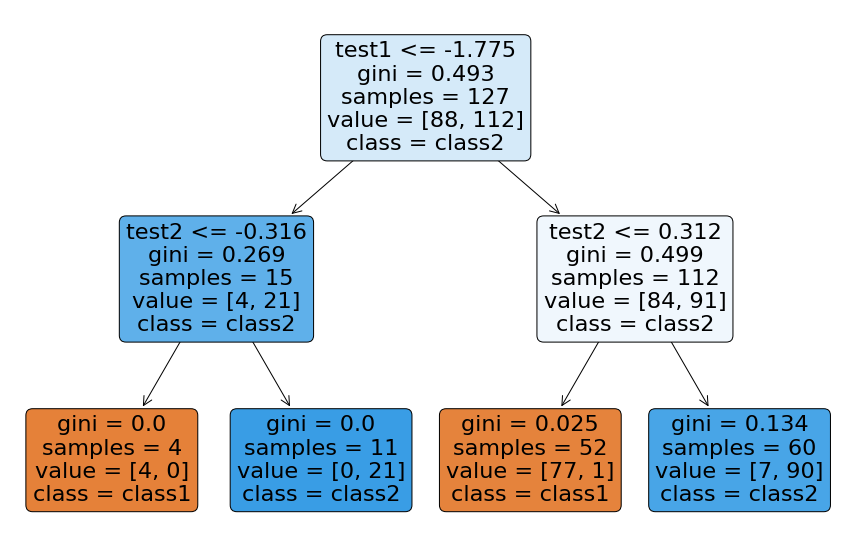

In [301]:
fig = plt.figure(figsize=(15, 10))
_ = plot_tree(clf.estimators_[3], 
          feature_names=data['feature_names'],
          class_names=data['class_names'],
          filled=True, impurity=True,
          rounded=True)

In [87]:
clf.estimators_[9].tree_.value

array([[[111.,  89.]],

       [[106.,  71.]],

       [[102.,   1.]],

       [[  4.,  70.]],

       [[  5.,  18.]],

       [[  5.,  12.]],

       [[  0.,   6.]]])

In [98]:
clf.estimators_[9].tree_.node_count

7

In [89]:
clf.estimators_[9].tree_.children_left

array([ 1,  2, -1, -1,  5, -1, -1], dtype=int64)

In [90]:
clf.estimators_[9].tree_.children_right

array([ 4,  3, -1, -1,  6, -1, -1], dtype=int64)

In [96]:
clf.estimators_[9].tree_.threshold

array([ 2.21648538,  0.3116643 , -2.        , -2.        ,  2.94259477,
       -2.        , -2.        ])

In [97]:
clf.estimators_[9].tree_.feature

array([ 0,  1, -2, -2,  0, -2, -2], dtype=int64)

# Árvores de Decisão com lógica probabilística

### Representação de uma Árvore de Decisão no modelo do CONDSAT

### Representação de uma Floresta Aleatória no modelo do CONDSAT

### Equivalência entre o Modelo Original e CONDSAT

# Experimentos (Resultados)

### Experimentos em datasets artificiais

### Experimentos em datasets reais (clássicos)